# <center>Домашнее задание по занятию 22
# <center>GANs
## 1. Сделать сверточный GANs

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('drive/My Drive/Colab Notebooks/neural_OTUS')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np
import os 

%matplotlib inline

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [4]:
root_folder = 'FC_GAN_results'
fixed_folder = root_folder + '/Fixed_results'

if os.path.isdir(root_folder):
    !rm -r $root_folder
os.mkdir(root_folder)
os.mkdir(fixed_folder)

In [5]:
mnist_tanh = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])

In [6]:
# Batch size during training
batch_size = 250

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 28

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100  # prior_size

# Size of feature maps in generator
ngf = 28

# Size of feature maps in discriminator
ndf = 28

# Number of training epochs
num_epochs = 100

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [7]:
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
device

device(type='cuda', index=0)

In [8]:
train_loader, valid_loader, test_loader = mnist(batch_size=batch_size, valid=10000, transform=mnist_tanh, 
                                                path='./../MNIST_data')

In [9]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [10]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, nc, 4, 2, 3, bias=False),
            nn.Tanh()
            # state size. (nc) x 28 x 28
        )

    def forward(self, input):
        return self.main(input)

In [11]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 224, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(224, 112, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(112, 56, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(56, 1, kernel_size=(4, 4), stride=(2, 2), padding=(3, 3), bias=False)
    (10): Tanh()
  )
)


In [12]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 28 x 28
            nn.Conv2d(nc, ndf * 2, 4, 2, 3, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [13]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 56, kernel_size=(4, 4), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(56, 112, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(112, 224, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(224, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (10): Sigmoid()
  )
)


In [14]:
G_optimizer = optim.Adam(netG.parameters(), lr=lr)
D_optimizer = optim.Adam(netD.parameters(), lr=lr)

In [15]:
# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_z = torch.randn([50, nz, 1, 1], device=device)

In [16]:
train_log = {'G': [], 'D': []}
test_log = {'G': [], 'D': []}

In [17]:
batch_zeros = torch.zeros((batch_size, 1), device=device)
batch_ones = torch.ones((batch_size, 1), device=device)

In [18]:
def train(epoch, G, D, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        # train D
        D.zero_grad()
        G.zero_grad()
        z = torch.randn([batch_size, nz, 1, 1], device=device)
        fake_pred = D(G(z)).reshape(-1, 1)
        true_pred = D(data).reshape(-1, 1)
        
        fake_loss = F.binary_cross_entropy(fake_pred, batch_zeros)
        true_loss = F.binary_cross_entropy(true_pred, batch_ones)
        
        D_loss = 0.5*(fake_loss + true_loss)
        
        D_loss.backward()
        D_optimizer.step()
        
        # train G
        D.zero_grad()
        G.zero_grad()
        z = torch.randn([batch_size, nz, 1, 1], device=device)
        fake_pred = D(G(z)).reshape(-1, 1)
        G_loss = F.binary_cross_entropy(fake_pred, batch_ones)
        
        G_loss.backward()
        
        G_optimizer.step()
            
        if batch_idx % 100 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = 'G: {:.4f}, D: {:.4f}'.format(G_loss.item(), D_loss.item())
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = 'G: {:.4f}, D: {:.4f}'.format(G_loss.item(), D_loss.item())
        print(line + losses)
        log['G'].append(G_loss.item())
        log['D'].append(D_loss.item())

In [19]:
def test(G, D, loader, epoch, log=None):
    test_size = len(loader)
    G_loss = 0.
    D_loss = 0.
    test_loss = {'G': 0., 'D': 0.}
    with torch.no_grad():
        for data, _ in loader:
            data = data.to(device)
            z = torch.randn([batch_size, nz, 1, 1], device=device)
            fake_pred = D(G(z)).reshape(-1, 1)
            true_pred = D(data).reshape(-1, 1)
        
            fake_loss = F.binary_cross_entropy(fake_pred, batch_zeros).item()
            true_loss = F.binary_cross_entropy(true_pred, batch_ones).item()
            
            D_loss += 0.5*(fake_loss + true_loss)
            G_loss += F.binary_cross_entropy(fake_pred, batch_ones).item()
    
    G_loss /= test_size
    D_loss /= test_size

    fixed_gen = G(fixed_z).data.cpu().numpy()
    
    plot_mnist(fixed_gen, (5, 10), True, fixed_folder + '/%03d.png' % epoch)
    report = 'Test losses. G: {:.4f}, D: {:.4f}'.format(G_loss, D_loss)
    log['G'].append(G_loss)
    log['D'].append(D_loss)
    print(report, '\n')

Train Epoch: 1 [0/50000 (0%)]	Losses G: 1.2938, D: 0.9140
Train Epoch: 1 [25000/50000 (50%)]	Losses G: 6.5368, D: 0.0208
Train Epoch: 1 [50000/50000 (100%)]	Losses G: 6.8020, D: 0.0058


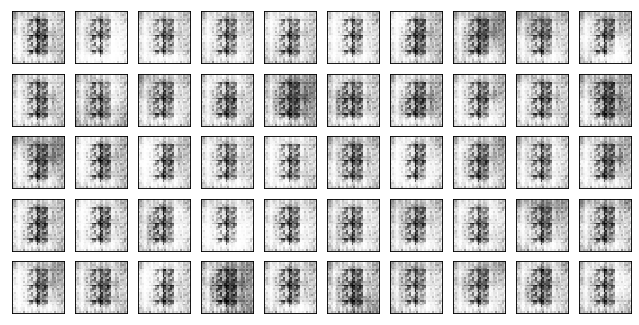

Test losses. G: 2.4422, D: 0.2425 

Train Epoch: 2 [0/50000 (0%)]	Losses G: 6.6288, D: 0.0069
Train Epoch: 2 [25000/50000 (50%)]	Losses G: 7.3148, D: 0.0110
Train Epoch: 2 [50000/50000 (100%)]	Losses G: 7.2713, D: 0.0063


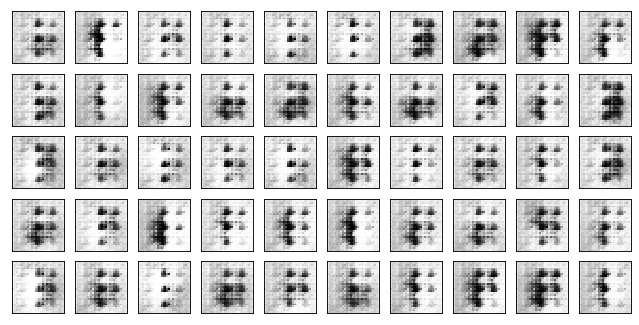

Test losses. G: 2.4797, D: 0.1408 

Train Epoch: 3 [0/50000 (0%)]	Losses G: 7.0951, D: 0.0039
Train Epoch: 3 [25000/50000 (50%)]	Losses G: 9.2255, D: 0.0145
Train Epoch: 3 [50000/50000 (100%)]	Losses G: 7.5947, D: 0.0071


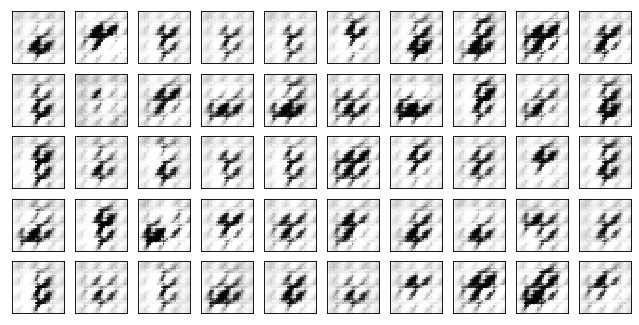

Test losses. G: 4.1188, D: 0.0877 

Train Epoch: 4 [0/50000 (0%)]	Losses G: 7.2217, D: 0.0048
Train Epoch: 4 [25000/50000 (50%)]	Losses G: 7.5218, D: 0.0013
Train Epoch: 4 [50000/50000 (100%)]	Losses G: 7.5589, D: 0.0037


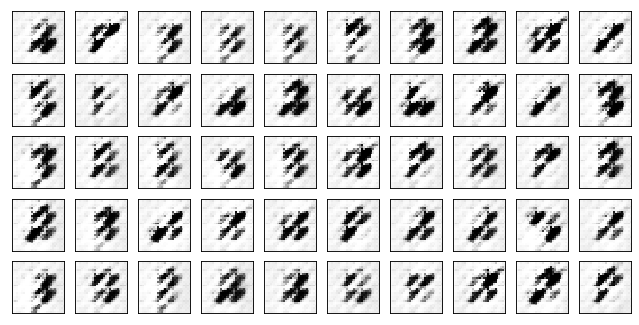

Test losses. G: 3.4758, D: 0.1307 

Train Epoch: 5 [0/50000 (0%)]	Losses G: 7.5839, D: 0.0027
Train Epoch: 5 [25000/50000 (50%)]	Losses G: 7.2250, D: 0.0031
Train Epoch: 5 [50000/50000 (100%)]	Losses G: 10.4599, D: 0.0035


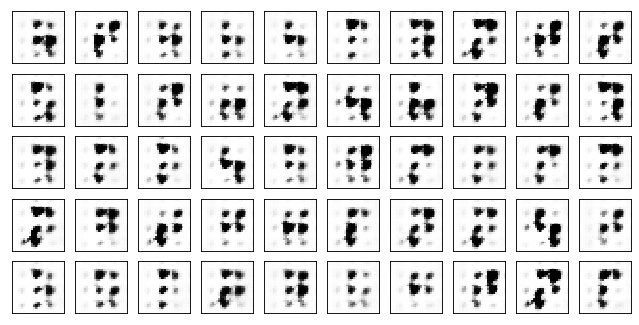

Test losses. G: 6.3044, D: 0.0413 

Train Epoch: 6 [0/50000 (0%)]	Losses G: 9.3811, D: 0.0042
Train Epoch: 6 [25000/50000 (50%)]	Losses G: 7.4014, D: 0.0009
Train Epoch: 6 [50000/50000 (100%)]	Losses G: 8.2581, D: 0.0062


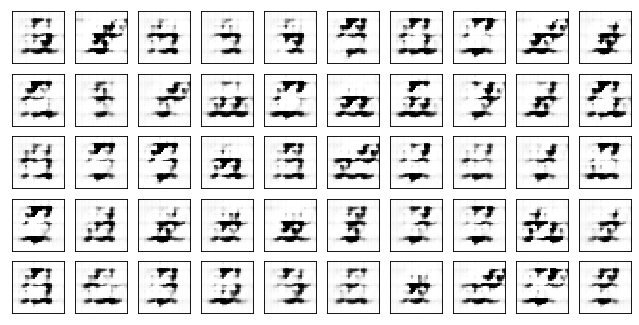

Test losses. G: 4.3425, D: 0.0200 

Train Epoch: 7 [0/50000 (0%)]	Losses G: 8.4438, D: 0.0054
Train Epoch: 7 [25000/50000 (50%)]	Losses G: 9.6148, D: 0.0030
Train Epoch: 7 [50000/50000 (100%)]	Losses G: 8.7054, D: 0.0008


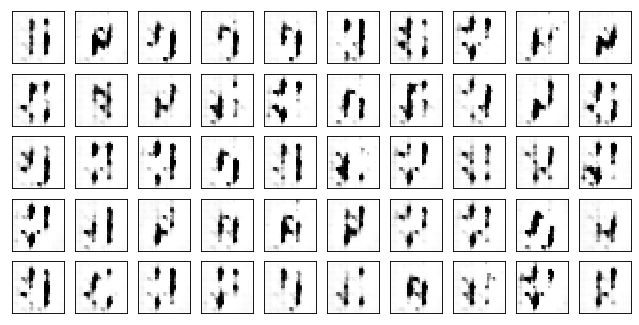

Test losses. G: 5.2541, D: 0.0096 

Train Epoch: 8 [0/50000 (0%)]	Losses G: 8.8613, D: 0.0014
Train Epoch: 8 [25000/50000 (50%)]	Losses G: 8.9512, D: 0.0046
Train Epoch: 8 [50000/50000 (100%)]	Losses G: 13.4414, D: 0.0161


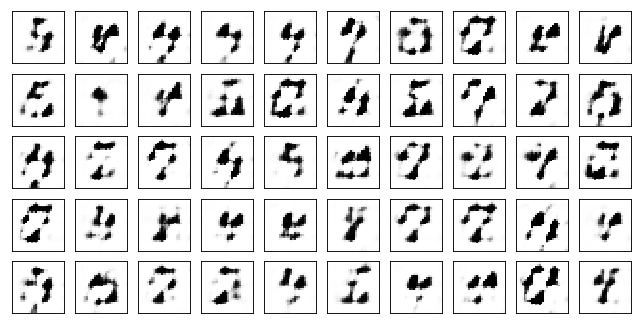

Test losses. G: 11.2246, D: 0.2196 

Train Epoch: 9 [0/50000 (0%)]	Losses G: 13.5048, D: 0.0710
Train Epoch: 9 [25000/50000 (50%)]	Losses G: 5.9856, D: 0.0101
Train Epoch: 9 [50000/50000 (100%)]	Losses G: 6.4804, D: 0.0170


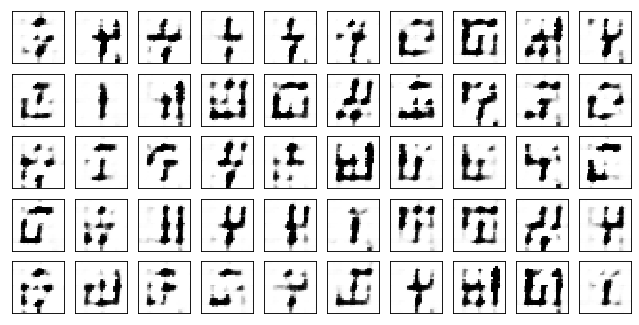

Test losses. G: 4.4664, D: 0.0349 

Train Epoch: 10 [0/50000 (0%)]	Losses G: 6.3273, D: 0.0098
Train Epoch: 10 [25000/50000 (50%)]	Losses G: 5.8094, D: 0.0165
Train Epoch: 10 [50000/50000 (100%)]	Losses G: 6.6933, D: 0.0179


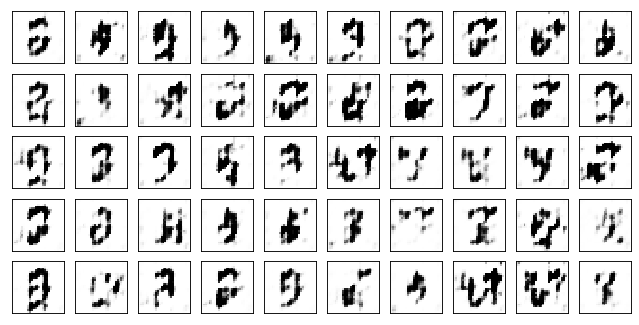

Test losses. G: 4.6049, D: 0.0557 

Train Epoch: 11 [0/50000 (0%)]	Losses G: 7.0908, D: 0.0168
Train Epoch: 11 [25000/50000 (50%)]	Losses G: 7.1927, D: 0.0071
Train Epoch: 11 [50000/50000 (100%)]	Losses G: 6.7893, D: 0.0071


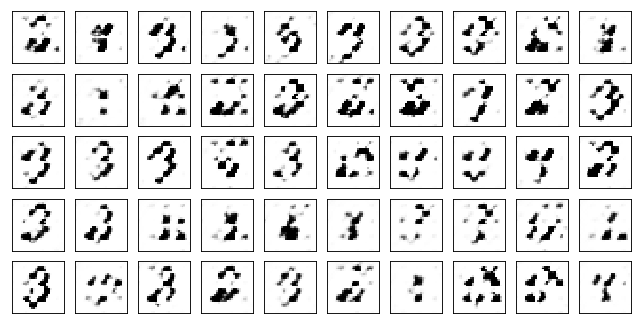

Test losses. G: 3.9911, D: 0.0395 

Train Epoch: 12 [0/50000 (0%)]	Losses G: 6.8960, D: 0.0076
Train Epoch: 12 [25000/50000 (50%)]	Losses G: 7.0757, D: 0.0165
Train Epoch: 12 [50000/50000 (100%)]	Losses G: 7.3111, D: 0.0060


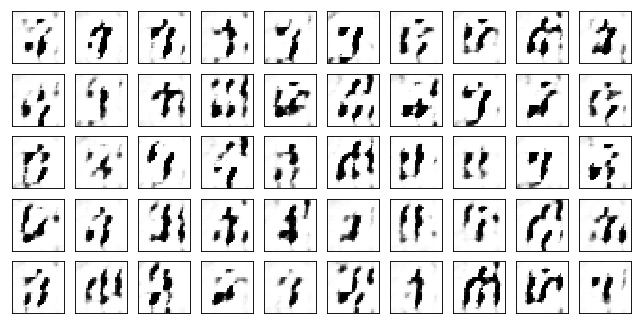

Test losses. G: 5.2971, D: 0.0298 

Train Epoch: 13 [0/50000 (0%)]	Losses G: 7.0873, D: 0.0046
Train Epoch: 13 [25000/50000 (50%)]	Losses G: 6.1993, D: 0.0121
Train Epoch: 13 [50000/50000 (100%)]	Losses G: 7.8110, D: 0.0034


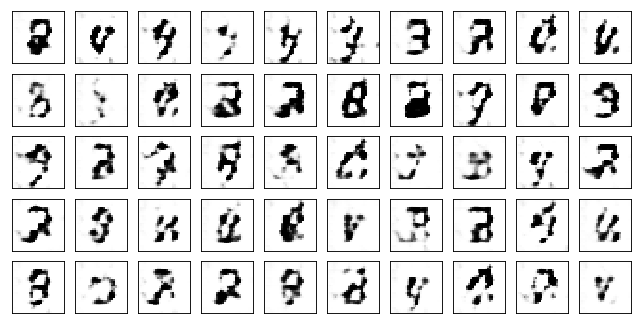

Test losses. G: 4.2462, D: 0.0619 

Train Epoch: 14 [0/50000 (0%)]	Losses G: 7.2163, D: 0.0049
Train Epoch: 14 [25000/50000 (50%)]	Losses G: 6.0304, D: 0.0266
Train Epoch: 14 [50000/50000 (100%)]	Losses G: 4.8192, D: 0.0191


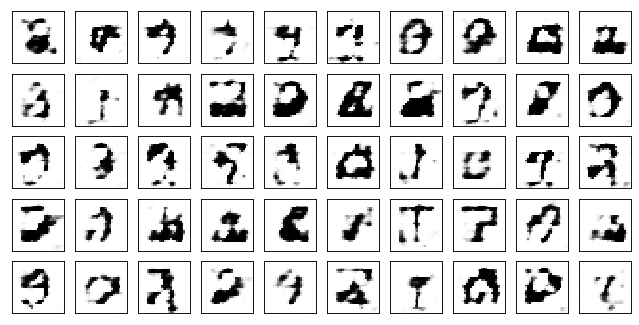

Test losses. G: 3.7510, D: 0.1117 

Train Epoch: 15 [0/50000 (0%)]	Losses G: 4.8703, D: 0.0288
Train Epoch: 15 [25000/50000 (50%)]	Losses G: 4.5075, D: 0.0244
Train Epoch: 15 [50000/50000 (100%)]	Losses G: 5.2921, D: 0.0205


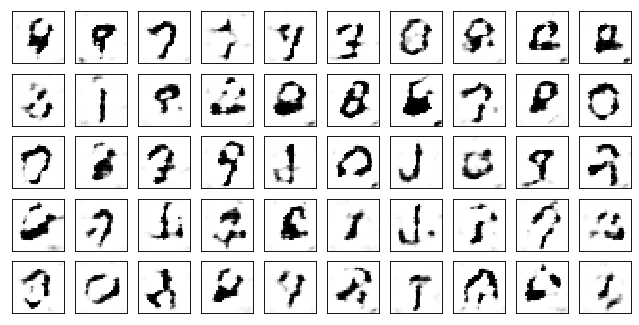

Test losses. G: 3.4855, D: 0.1313 

Train Epoch: 16 [0/50000 (0%)]	Losses G: 5.0406, D: 0.0258
Train Epoch: 16 [25000/50000 (50%)]	Losses G: 5.9942, D: 0.0173
Train Epoch: 16 [50000/50000 (100%)]	Losses G: 5.1629, D: 0.0430


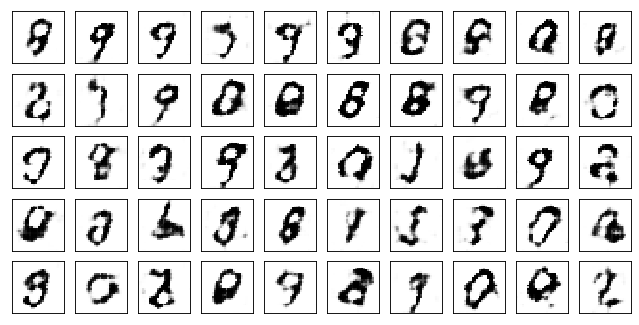

Test losses. G: 5.2230, D: 0.2274 

Train Epoch: 17 [0/50000 (0%)]	Losses G: 4.6394, D: 0.0274
Train Epoch: 17 [25000/50000 (50%)]	Losses G: 4.3562, D: 0.1064
Train Epoch: 17 [50000/50000 (100%)]	Losses G: 5.7423, D: 0.0657


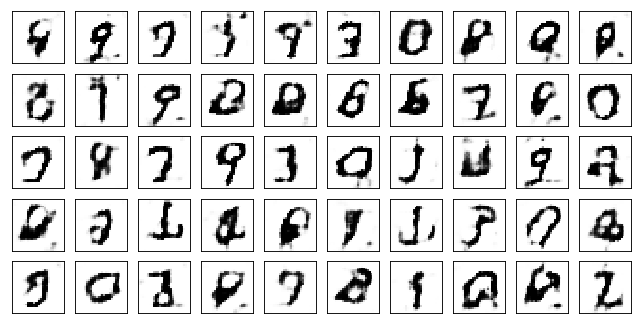

Test losses. G: 4.7415, D: 0.1780 

Train Epoch: 18 [0/50000 (0%)]	Losses G: 5.5238, D: 0.0612
Train Epoch: 18 [25000/50000 (50%)]	Losses G: 3.9256, D: 0.0365
Train Epoch: 18 [50000/50000 (100%)]	Losses G: 4.8393, D: 0.0985


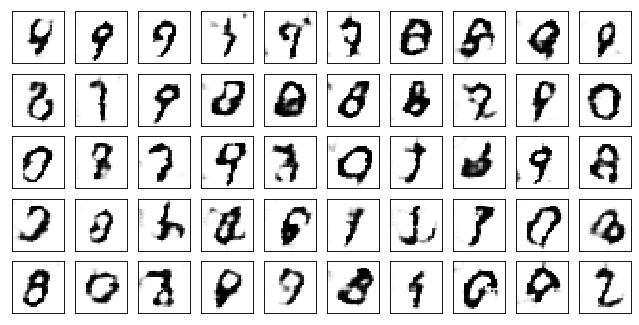

Test losses. G: 5.8218, D: 0.4113 

Train Epoch: 19 [0/50000 (0%)]	Losses G: 3.2010, D: 0.0827
Train Epoch: 19 [25000/50000 (50%)]	Losses G: 3.8482, D: 0.1214
Train Epoch: 19 [50000/50000 (100%)]	Losses G: 3.2222, D: 0.0848


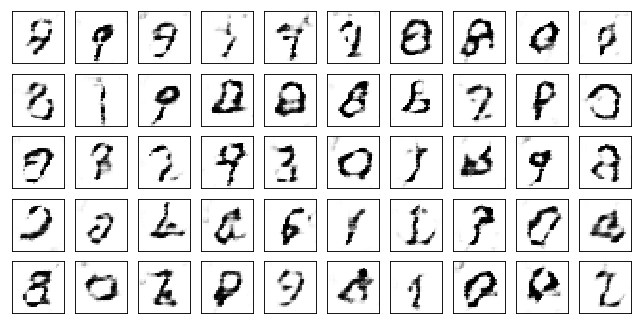

Test losses. G: 1.7253, D: 0.2273 

Train Epoch: 20 [0/50000 (0%)]	Losses G: 4.5053, D: 0.0729
Train Epoch: 20 [25000/50000 (50%)]	Losses G: 5.8169, D: 0.0409
Train Epoch: 20 [50000/50000 (100%)]	Losses G: 4.5471, D: 0.0490


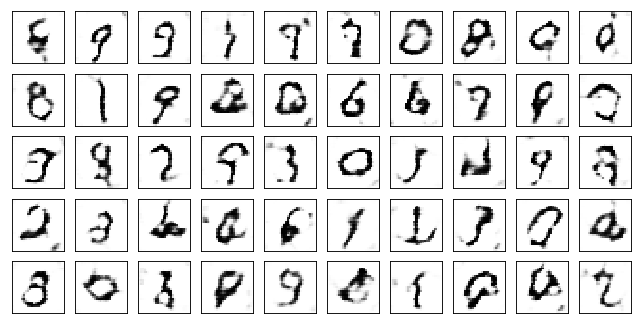

Test losses. G: 0.9707, D: 0.5025 

Train Epoch: 21 [0/50000 (0%)]	Losses G: 4.7726, D: 0.0547
Train Epoch: 21 [25000/50000 (50%)]	Losses G: 3.4746, D: 0.0866
Train Epoch: 21 [50000/50000 (100%)]	Losses G: 4.3545, D: 0.0838


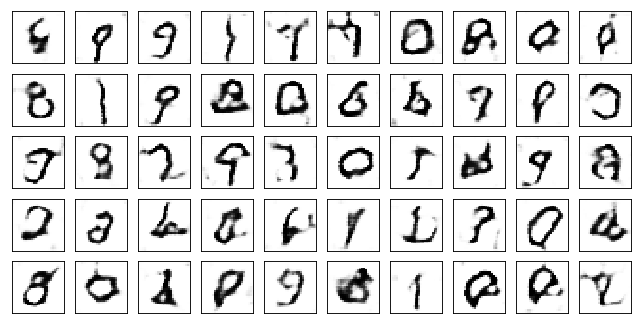

Test losses. G: 1.1841, D: 0.4033 

Train Epoch: 22 [0/50000 (0%)]	Losses G: 4.5860, D: 0.0818
Train Epoch: 22 [25000/50000 (50%)]	Losses G: 3.9328, D: 0.1424
Train Epoch: 22 [50000/50000 (100%)]	Losses G: 5.0705, D: 0.1305


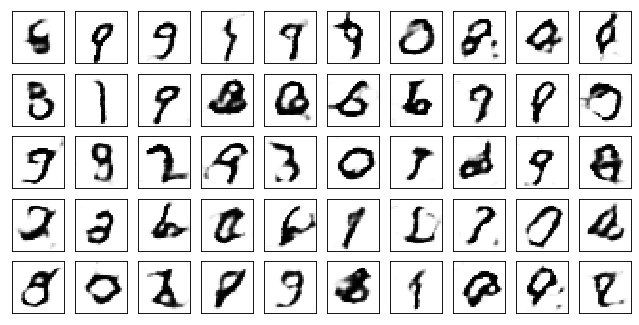

Test losses. G: 4.2437, D: 0.4490 

Train Epoch: 23 [0/50000 (0%)]	Losses G: 3.2360, D: 0.1726
Train Epoch: 23 [25000/50000 (50%)]	Losses G: 3.4129, D: 0.1456
Train Epoch: 23 [50000/50000 (100%)]	Losses G: 3.7756, D: 0.1020


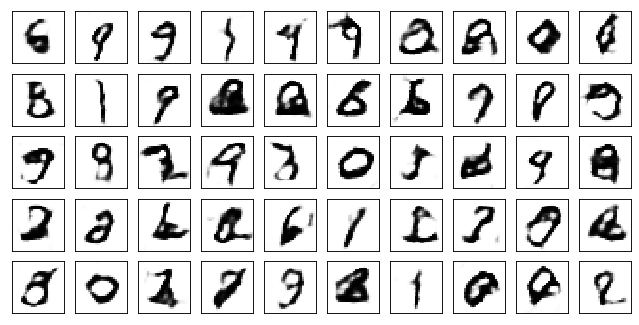

Test losses. G: 2.5279, D: 0.2015 

Train Epoch: 24 [0/50000 (0%)]	Losses G: 2.8599, D: 0.0510
Train Epoch: 24 [25000/50000 (50%)]	Losses G: 4.2086, D: 0.0694
Train Epoch: 24 [50000/50000 (100%)]	Losses G: 3.8093, D: 0.0506


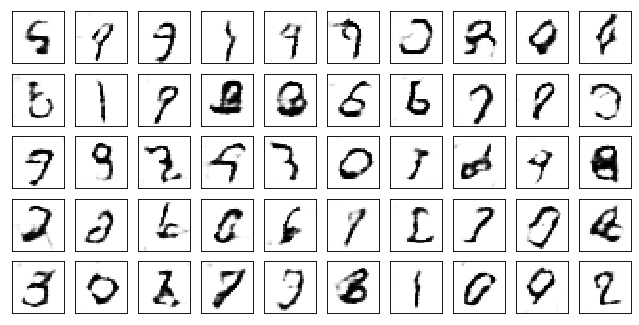

Test losses. G: 0.6005, D: 0.7143 

Train Epoch: 25 [0/50000 (0%)]	Losses G: 5.1453, D: 0.0700
Train Epoch: 25 [25000/50000 (50%)]	Losses G: 4.1083, D: 0.1098
Train Epoch: 25 [50000/50000 (100%)]	Losses G: 3.7577, D: 0.2663


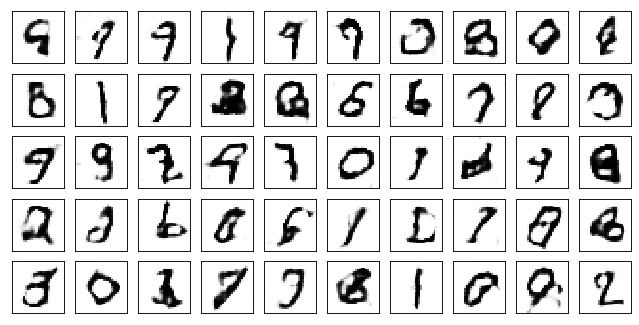

Test losses. G: 1.4164, D: 0.3945 

Train Epoch: 26 [0/50000 (0%)]	Losses G: 2.5405, D: 0.1537
Train Epoch: 26 [25000/50000 (50%)]	Losses G: 3.3398, D: 0.0942
Train Epoch: 26 [50000/50000 (100%)]	Losses G: 4.2128, D: 0.0974


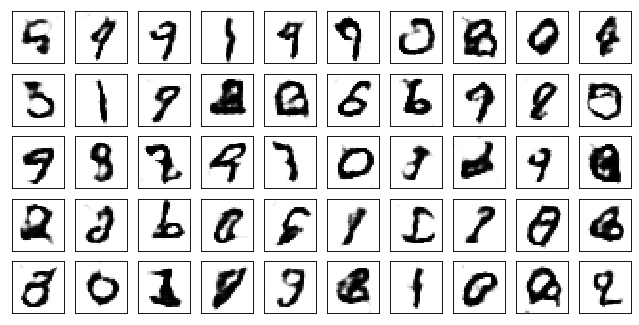

Test losses. G: 5.8602, D: 1.2567 

Train Epoch: 27 [0/50000 (0%)]	Losses G: 4.6087, D: 0.0790
Train Epoch: 27 [25000/50000 (50%)]	Losses G: 4.2539, D: 0.0648
Train Epoch: 27 [50000/50000 (100%)]	Losses G: 4.1346, D: 0.0772


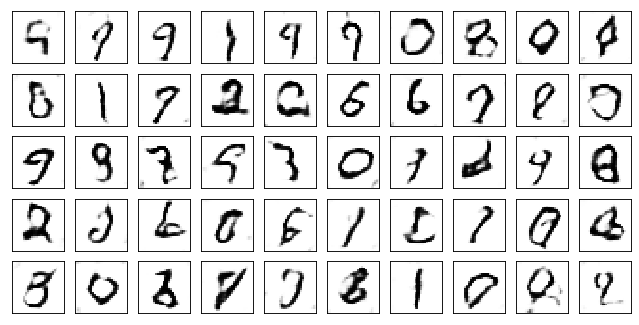

Test losses. G: 1.6690, D: 0.3488 

Train Epoch: 28 [0/50000 (0%)]	Losses G: 4.5392, D: 0.0388
Train Epoch: 28 [25000/50000 (50%)]	Losses G: 2.2540, D: 0.1125
Train Epoch: 28 [50000/50000 (100%)]	Losses G: 1.8381, D: 0.1482


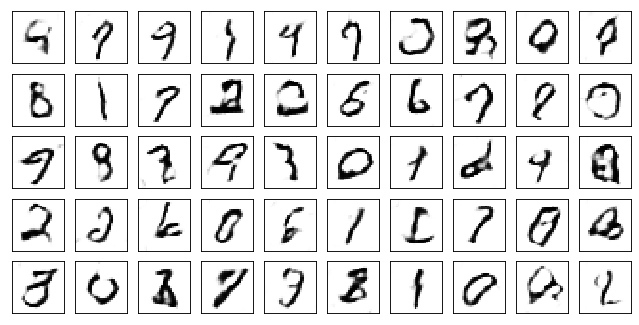

Test losses. G: 1.5097, D: 0.3547 

Train Epoch: 29 [0/50000 (0%)]	Losses G: 3.1785, D: 0.3347
Train Epoch: 29 [25000/50000 (50%)]	Losses G: 3.7121, D: 0.1245
Train Epoch: 29 [50000/50000 (100%)]	Losses G: 1.3306, D: 0.1426


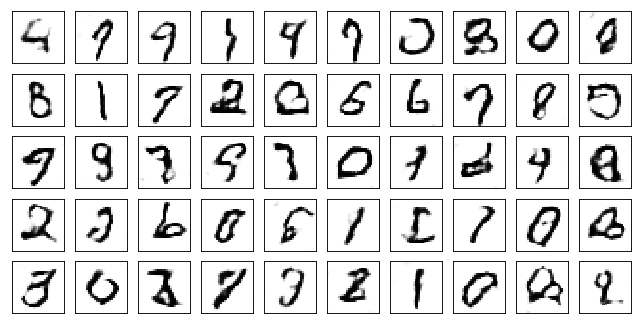

Test losses. G: 2.1156, D: 0.3222 

Train Epoch: 30 [0/50000 (0%)]	Losses G: 2.6545, D: 0.3383
Train Epoch: 30 [25000/50000 (50%)]	Losses G: 3.1767, D: 0.2748
Train Epoch: 30 [50000/50000 (100%)]	Losses G: 2.3538, D: 0.2492


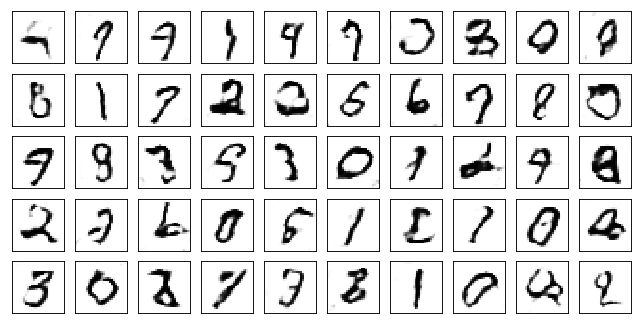

Test losses. G: 2.3879, D: 0.3139 

Train Epoch: 31 [0/50000 (0%)]	Losses G: 3.9645, D: 0.1647
Train Epoch: 31 [25000/50000 (50%)]	Losses G: 2.1574, D: 0.2843
Train Epoch: 31 [50000/50000 (100%)]	Losses G: 3.8538, D: 0.1402


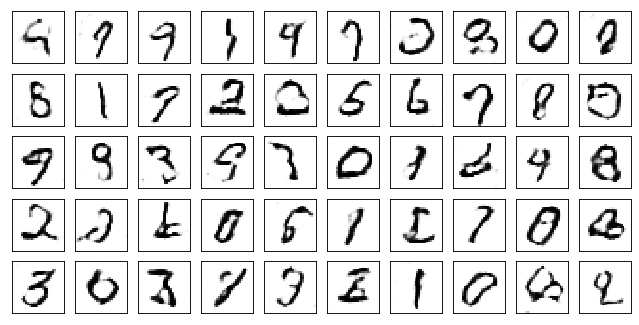

Test losses. G: 6.4734, D: 1.3853 

Train Epoch: 32 [0/50000 (0%)]	Losses G: 4.5893, D: 0.0714
Train Epoch: 32 [25000/50000 (50%)]	Losses G: 2.4318, D: 0.1618
Train Epoch: 32 [50000/50000 (100%)]	Losses G: 2.6872, D: 0.1459


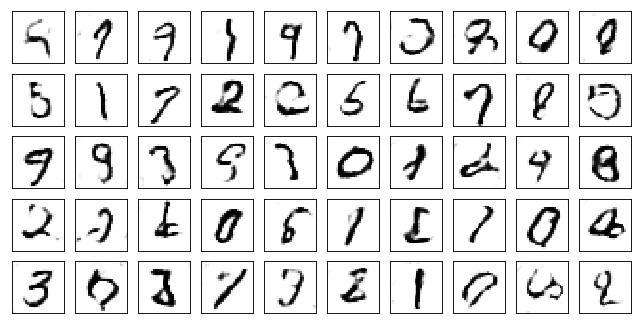

Test losses. G: 0.2312, D: 1.2075 

Train Epoch: 33 [0/50000 (0%)]	Losses G: 2.7702, D: 0.1443
Train Epoch: 33 [25000/50000 (50%)]	Losses G: 3.6454, D: 0.1871
Train Epoch: 33 [50000/50000 (100%)]	Losses G: 2.8638, D: 0.2040


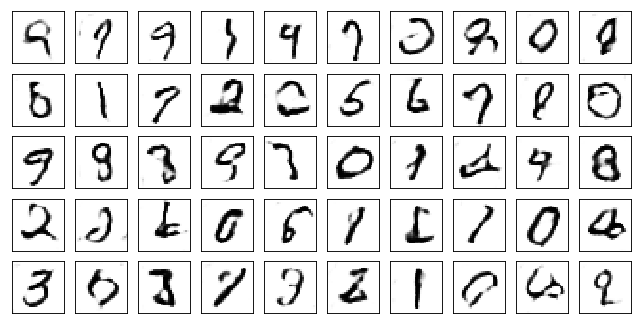

Test losses. G: 1.4559, D: 0.4235 

Train Epoch: 34 [0/50000 (0%)]	Losses G: 3.1367, D: 0.1984
Train Epoch: 34 [25000/50000 (50%)]	Losses G: 3.3166, D: 0.1850
Train Epoch: 34 [50000/50000 (100%)]	Losses G: 3.3127, D: 0.1676


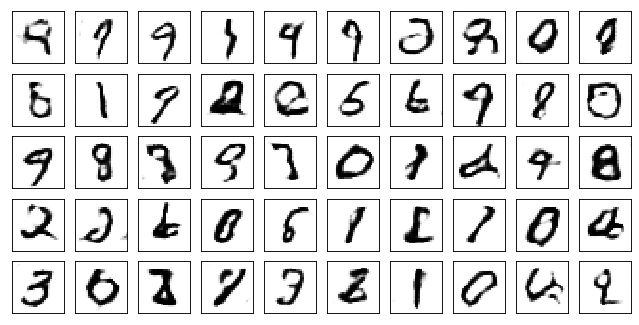

Test losses. G: 3.0499, D: 0.4964 

Train Epoch: 35 [0/50000 (0%)]	Losses G: 2.7965, D: 0.2509
Train Epoch: 35 [25000/50000 (50%)]	Losses G: 3.3210, D: 0.1515
Train Epoch: 35 [50000/50000 (100%)]	Losses G: 3.0087, D: 0.2741


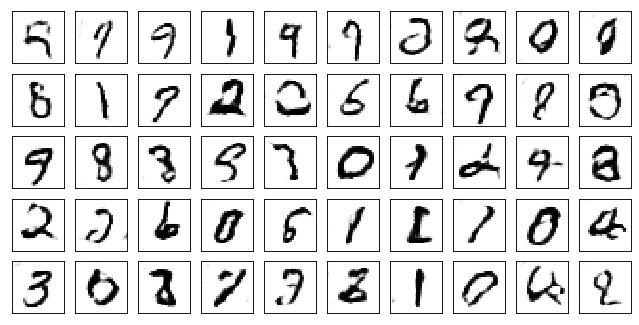

Test losses. G: 4.1177, D: 0.9783 

Train Epoch: 36 [0/50000 (0%)]	Losses G: 0.8671, D: 0.3214
Train Epoch: 36 [25000/50000 (50%)]	Losses G: 3.0144, D: 0.1503
Train Epoch: 36 [50000/50000 (100%)]	Losses G: 2.9005, D: 0.1937


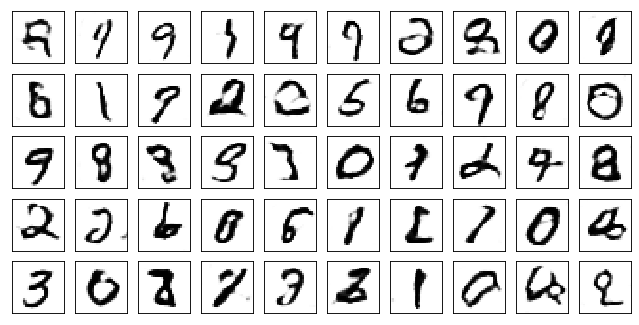

Test losses. G: 2.6083, D: 0.4995 

Train Epoch: 37 [0/50000 (0%)]	Losses G: 2.3795, D: 0.1705
Train Epoch: 37 [25000/50000 (50%)]	Losses G: 2.8119, D: 0.1926
Train Epoch: 37 [50000/50000 (100%)]	Losses G: 1.0176, D: 0.3260


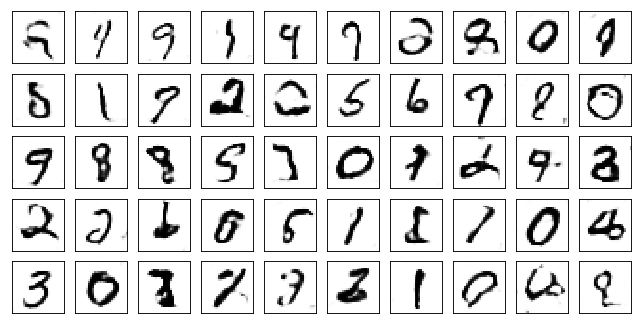

Test losses. G: 0.2248, D: 1.1921 

Train Epoch: 38 [0/50000 (0%)]	Losses G: 2.0765, D: 0.3274
Train Epoch: 38 [25000/50000 (50%)]	Losses G: 3.2737, D: 0.1565
Train Epoch: 38 [50000/50000 (100%)]	Losses G: 1.8843, D: 0.1984


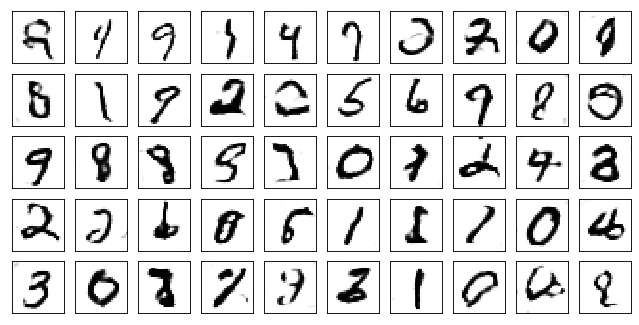

Test losses. G: 0.3909, D: 0.9063 

Train Epoch: 39 [0/50000 (0%)]	Losses G: 1.9793, D: 0.2462
Train Epoch: 39 [25000/50000 (50%)]	Losses G: 2.0401, D: 0.1552
Train Epoch: 39 [50000/50000 (100%)]	Losses G: 1.8560, D: 0.2162


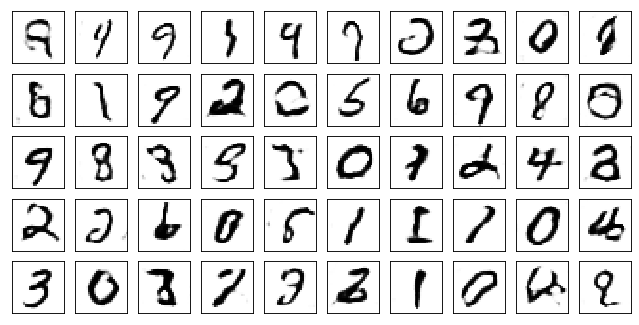

Test losses. G: 1.8318, D: 0.4519 

Train Epoch: 40 [0/50000 (0%)]	Losses G: 2.6266, D: 0.2356
Train Epoch: 40 [25000/50000 (50%)]	Losses G: 3.5661, D: 0.1129
Train Epoch: 40 [50000/50000 (100%)]	Losses G: 3.0737, D: 0.1277


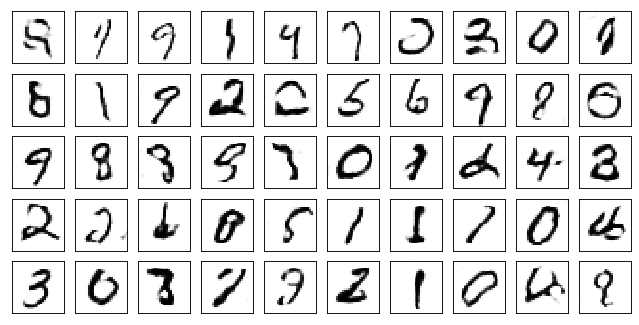

Test losses. G: 2.3489, D: 0.5096 

Train Epoch: 41 [0/50000 (0%)]	Losses G: 3.4391, D: 0.1534
Train Epoch: 41 [25000/50000 (50%)]	Losses G: 4.1525, D: 0.2720
Train Epoch: 41 [50000/50000 (100%)]	Losses G: 3.2659, D: 0.2243


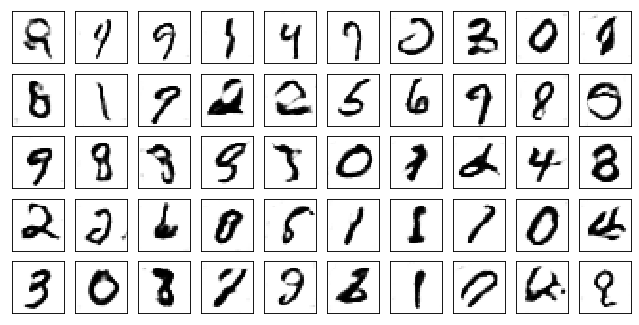

Test losses. G: 5.3652, D: 1.6754 

Train Epoch: 42 [0/50000 (0%)]	Losses G: 2.3753, D: 0.2345
Train Epoch: 42 [25000/50000 (50%)]	Losses G: 4.0905, D: 0.1460
Train Epoch: 42 [50000/50000 (100%)]	Losses G: 3.2583, D: 0.1235


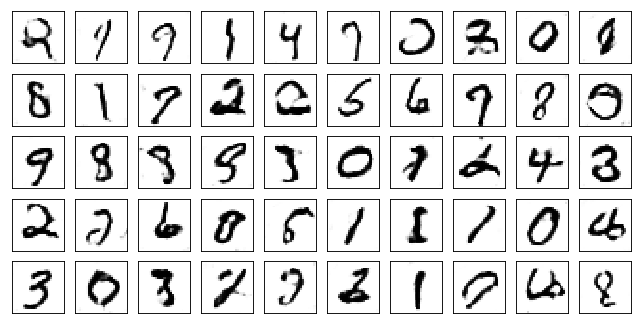

Test losses. G: 2.1862, D: 0.5057 

Train Epoch: 43 [0/50000 (0%)]	Losses G: 3.2924, D: 0.1532
Train Epoch: 43 [25000/50000 (50%)]	Losses G: 3.6107, D: 0.1882
Train Epoch: 43 [50000/50000 (100%)]	Losses G: 2.9201, D: 0.2309


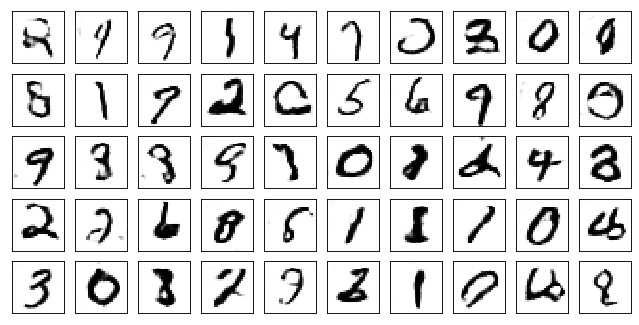

Test losses. G: 1.2918, D: 0.4516 

Train Epoch: 44 [0/50000 (0%)]	Losses G: 2.8720, D: 0.1908
Train Epoch: 44 [25000/50000 (50%)]	Losses G: 2.9337, D: 0.1852
Train Epoch: 44 [50000/50000 (100%)]	Losses G: 2.2418, D: 0.2035


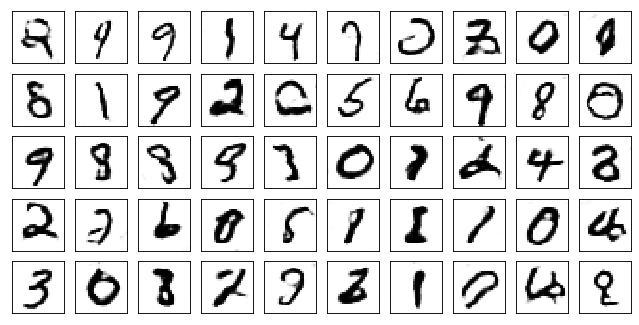

Test losses. G: 0.8807, D: 0.5485 

Train Epoch: 45 [0/50000 (0%)]	Losses G: 2.1485, D: 0.1654
Train Epoch: 45 [25000/50000 (50%)]	Losses G: 2.8682, D: 0.1453
Train Epoch: 45 [50000/50000 (100%)]	Losses G: 2.1113, D: 0.2997


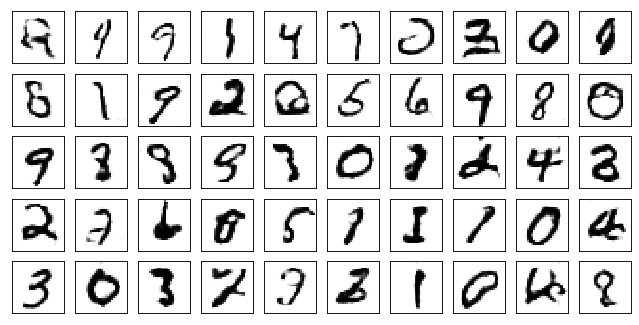

Test losses. G: 0.7800, D: 0.5637 

Train Epoch: 46 [0/50000 (0%)]	Losses G: 2.9808, D: 0.2501
Train Epoch: 46 [25000/50000 (50%)]	Losses G: 2.9001, D: 0.2228
Train Epoch: 46 [50000/50000 (100%)]	Losses G: 2.8446, D: 0.2178


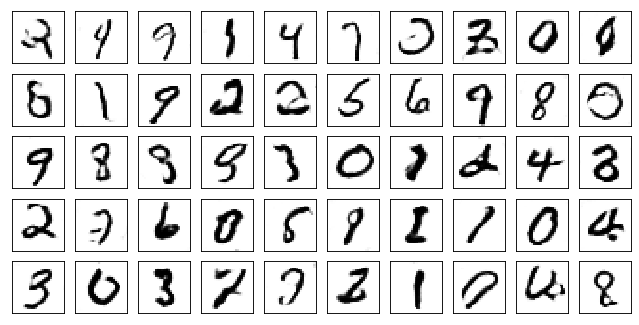

Test losses. G: 3.4165, D: 0.9159 

Train Epoch: 47 [0/50000 (0%)]	Losses G: 2.2559, D: 0.2474
Train Epoch: 47 [25000/50000 (50%)]	Losses G: 3.5646, D: 0.1955
Train Epoch: 47 [50000/50000 (100%)]	Losses G: 3.3709, D: 0.1028


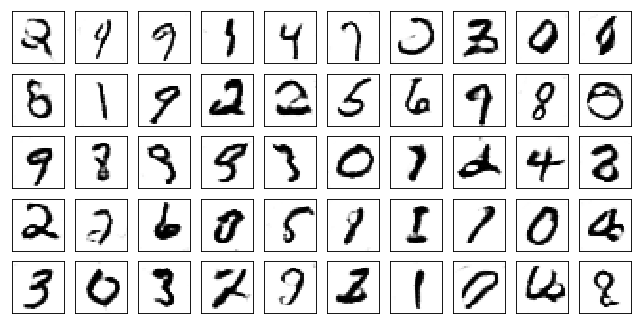

Test losses. G: 6.2031, D: 2.1241 

Train Epoch: 48 [0/50000 (0%)]	Losses G: 2.1470, D: 0.1495
Train Epoch: 48 [25000/50000 (50%)]	Losses G: 3.0568, D: 0.1991
Train Epoch: 48 [50000/50000 (100%)]	Losses G: 2.3402, D: 0.3842


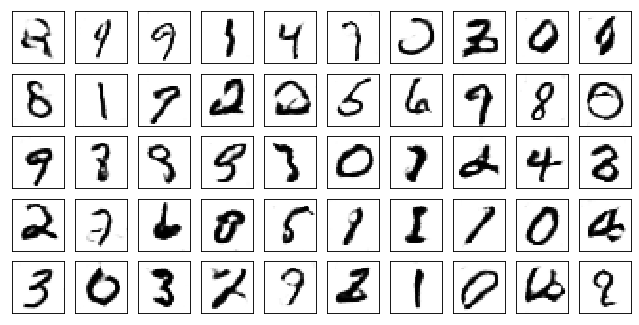

Test losses. G: 5.2143, D: 1.6795 

Train Epoch: 49 [0/50000 (0%)]	Losses G: 1.9627, D: 0.2068
Train Epoch: 49 [25000/50000 (50%)]	Losses G: 3.1619, D: 0.1240
Train Epoch: 49 [50000/50000 (100%)]	Losses G: 2.8811, D: 0.1360


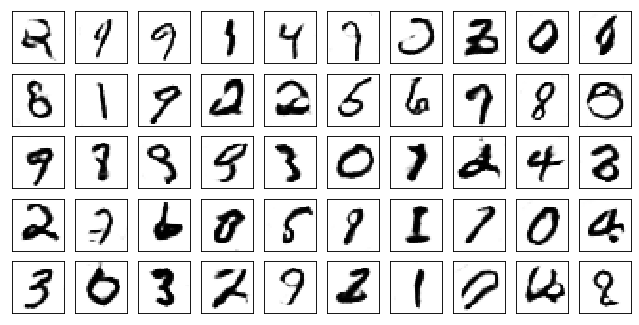

Test losses. G: 4.7950, D: 1.4437 

Train Epoch: 50 [0/50000 (0%)]	Losses G: 3.2511, D: 0.1207
Train Epoch: 50 [25000/50000 (50%)]	Losses G: 2.6956, D: 0.2857
Train Epoch: 50 [50000/50000 (100%)]	Losses G: 2.4628, D: 0.4085


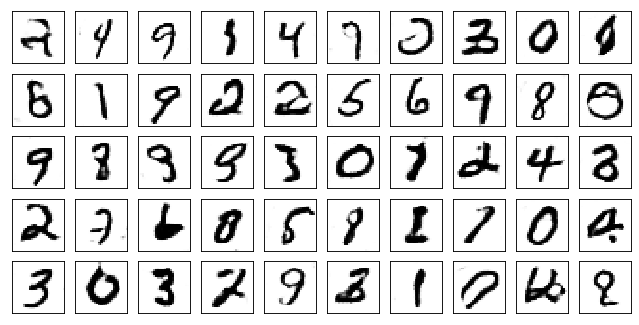

Test losses. G: 7.1937, D: 2.6484 

Train Epoch: 51 [0/50000 (0%)]	Losses G: 2.1394, D: 0.3142
Train Epoch: 51 [25000/50000 (50%)]	Losses G: 3.1766, D: 0.1560
Train Epoch: 51 [50000/50000 (100%)]	Losses G: 2.8809, D: 0.2332


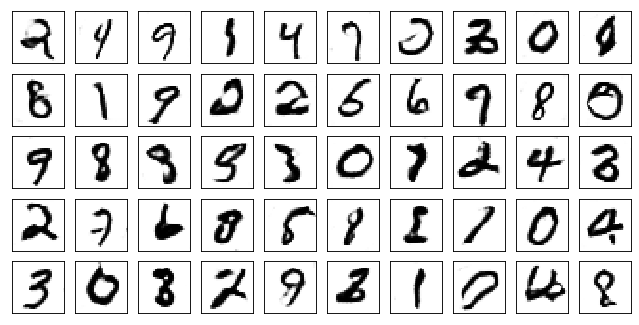

Test losses. G: 2.5260, D: 0.6404 

Train Epoch: 52 [0/50000 (0%)]	Losses G: 4.5978, D: 0.1172
Train Epoch: 52 [25000/50000 (50%)]	Losses G: 1.9916, D: 0.3292
Train Epoch: 52 [50000/50000 (100%)]	Losses G: 3.2415, D: 0.2463


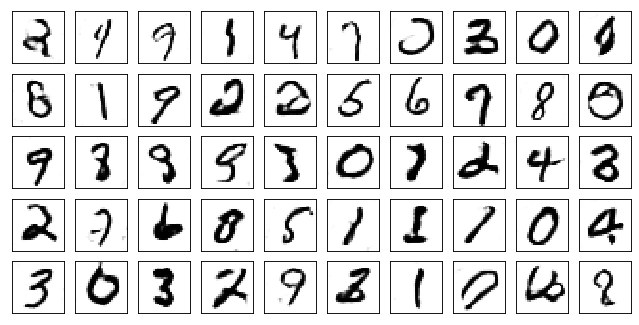

Test losses. G: 1.9123, D: 0.5364 

Train Epoch: 53 [0/50000 (0%)]	Losses G: 2.8423, D: 0.2255
Train Epoch: 53 [25000/50000 (50%)]	Losses G: 2.2126, D: 0.1674
Train Epoch: 53 [50000/50000 (100%)]	Losses G: 4.1590, D: 0.2745


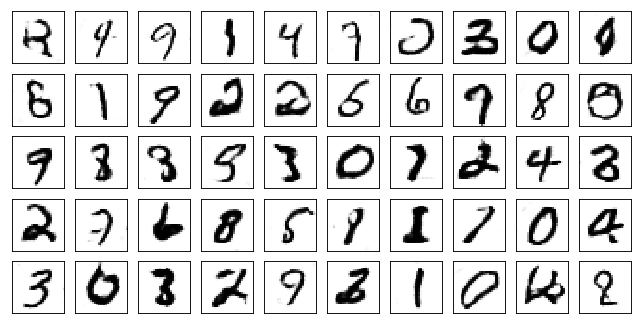

Test losses. G: 2.4280, D: 0.6412 

Train Epoch: 54 [0/50000 (0%)]	Losses G: 1.7977, D: 0.2321
Train Epoch: 54 [25000/50000 (50%)]	Losses G: 1.4530, D: 0.5338
Train Epoch: 54 [50000/50000 (100%)]	Losses G: 3.2559, D: 0.2895


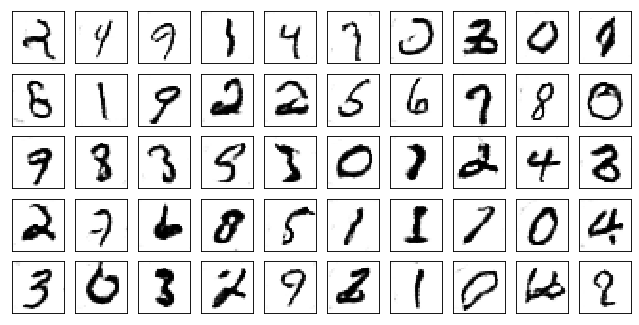

Test losses. G: 0.6189, D: 0.7199 

Train Epoch: 55 [0/50000 (0%)]	Losses G: 2.7544, D: 0.3473
Train Epoch: 55 [25000/50000 (50%)]	Losses G: 2.7973, D: 0.1587
Train Epoch: 55 [50000/50000 (100%)]	Losses G: 1.5917, D: 0.1994


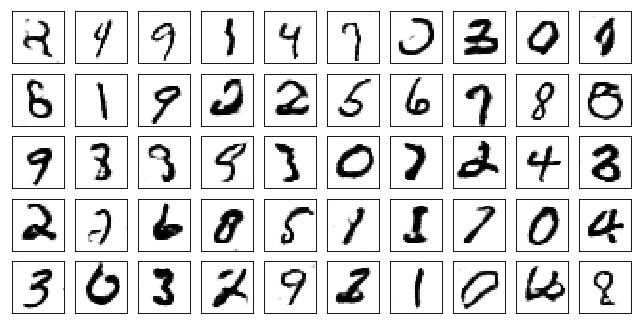

Test losses. G: 0.3484, D: 0.9030 

Train Epoch: 56 [0/50000 (0%)]	Losses G: 2.9772, D: 0.2231
Train Epoch: 56 [25000/50000 (50%)]	Losses G: 1.3665, D: 0.3178
Train Epoch: 56 [50000/50000 (100%)]	Losses G: 1.8332, D: 0.4524


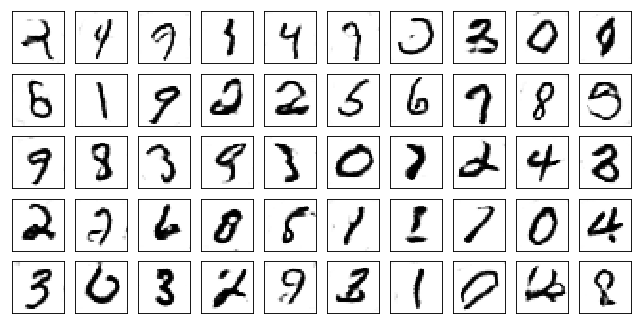

Test losses. G: 1.1951, D: 0.5105 

Train Epoch: 57 [0/50000 (0%)]	Losses G: 4.2598, D: 0.2403
Train Epoch: 57 [25000/50000 (50%)]	Losses G: 3.3917, D: 0.3188
Train Epoch: 57 [50000/50000 (100%)]	Losses G: 3.9279, D: 0.3669


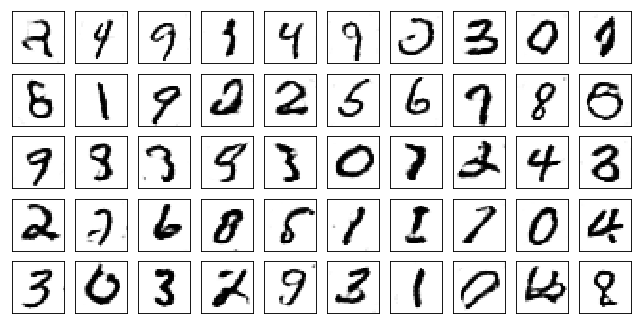

Test losses. G: 7.3314, D: 2.7682 

Train Epoch: 58 [0/50000 (0%)]	Losses G: 1.9067, D: 0.4590
Train Epoch: 58 [25000/50000 (50%)]	Losses G: 1.9246, D: 0.2644
Train Epoch: 58 [50000/50000 (100%)]	Losses G: 2.7028, D: 0.3298


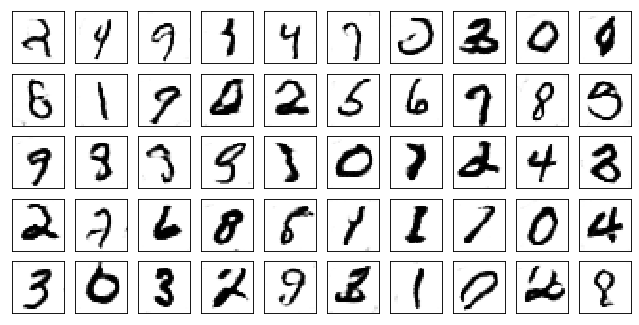

Test losses. G: 2.0764, D: 0.4973 

Train Epoch: 59 [0/50000 (0%)]	Losses G: 2.2580, D: 0.2064
Train Epoch: 59 [25000/50000 (50%)]	Losses G: 2.5874, D: 0.1764
Train Epoch: 59 [50000/50000 (100%)]	Losses G: 1.9947, D: 0.1531


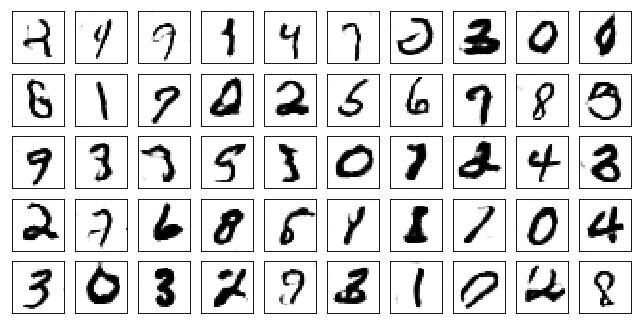

Test losses. G: 0.0288, D: 2.2954 

Train Epoch: 60 [0/50000 (0%)]	Losses G: 2.6500, D: 0.2006
Train Epoch: 60 [25000/50000 (50%)]	Losses G: 3.3421, D: 0.5051
Train Epoch: 60 [50000/50000 (100%)]	Losses G: 2.9530, D: 0.2437


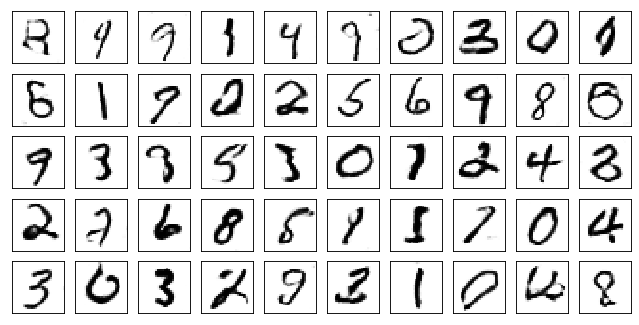

Test losses. G: 3.3076, D: 0.9813 

Train Epoch: 61 [0/50000 (0%)]	Losses G: 2.0375, D: 0.2048
Train Epoch: 61 [25000/50000 (50%)]	Losses G: 1.5819, D: 0.2705
Train Epoch: 61 [50000/50000 (100%)]	Losses G: 2.0164, D: 0.3901


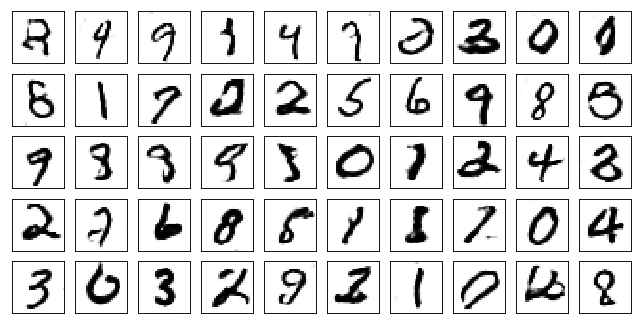

Test losses. G: 4.4569, D: 1.3176 

Train Epoch: 62 [0/50000 (0%)]	Losses G: 1.7543, D: 0.2257
Train Epoch: 62 [25000/50000 (50%)]	Losses G: 3.2954, D: 0.2242
Train Epoch: 62 [50000/50000 (100%)]	Losses G: 3.0127, D: 0.1941


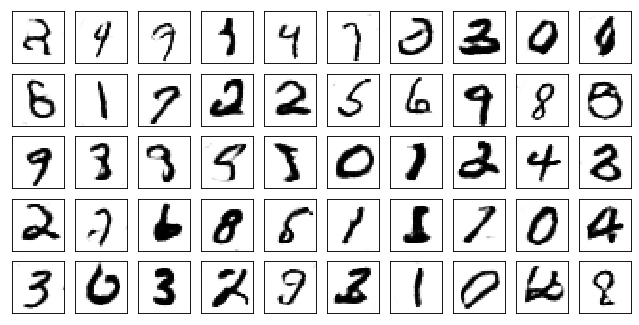

Test losses. G: 0.0606, D: 1.8792 

Train Epoch: 63 [0/50000 (0%)]	Losses G: 2.3748, D: 0.1219
Train Epoch: 63 [25000/50000 (50%)]	Losses G: 1.5400, D: 0.3429
Train Epoch: 63 [50000/50000 (100%)]	Losses G: 1.5303, D: 0.2065


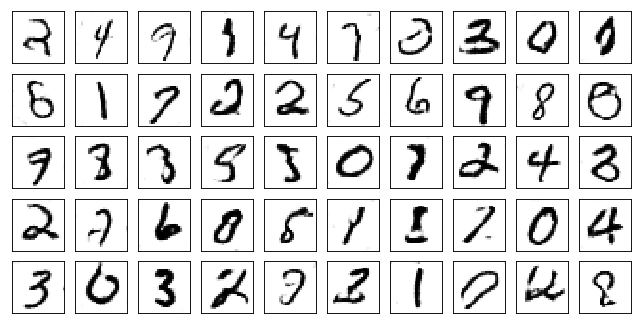

Test losses. G: 2.0642, D: 0.6644 

Train Epoch: 64 [0/50000 (0%)]	Losses G: 2.0397, D: 0.2827
Train Epoch: 64 [25000/50000 (50%)]	Losses G: 3.2812, D: 0.1298
Train Epoch: 64 [50000/50000 (100%)]	Losses G: 1.6271, D: 0.3093


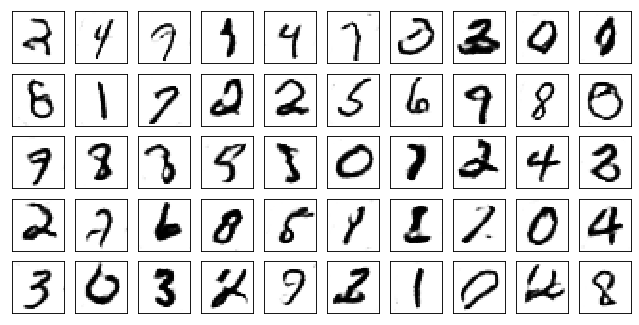

Test losses. G: 0.9448, D: 0.5293 

Train Epoch: 65 [0/50000 (0%)]	Losses G: 2.5285, D: 0.2903
Train Epoch: 65 [25000/50000 (50%)]	Losses G: 3.5310, D: 0.1630
Train Epoch: 65 [50000/50000 (100%)]	Losses G: 2.5669, D: 0.1686


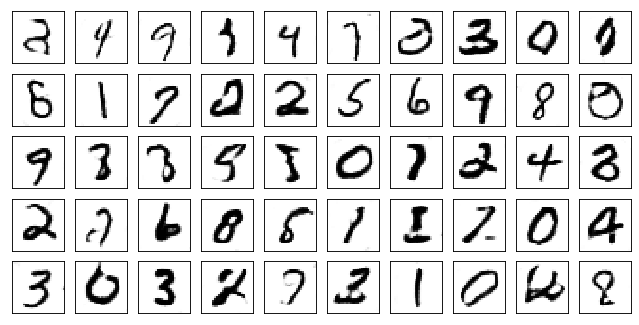

Test losses. G: 0.8007, D: 0.5863 

Train Epoch: 66 [0/50000 (0%)]	Losses G: 2.3473, D: 0.2372
Train Epoch: 66 [25000/50000 (50%)]	Losses G: 2.2136, D: 0.2918
Train Epoch: 66 [50000/50000 (100%)]	Losses G: 2.6122, D: 0.3919


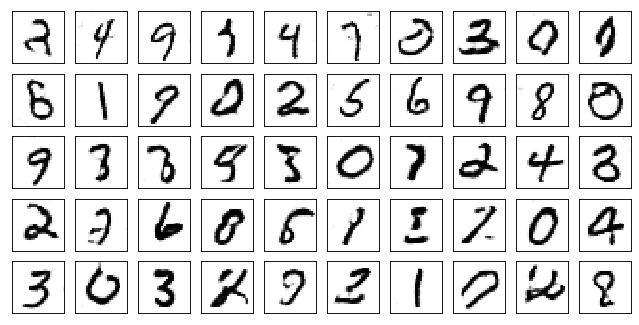

Test losses. G: 6.5470, D: 2.2918 

Train Epoch: 67 [0/50000 (0%)]	Losses G: 4.3372, D: 0.0986
Train Epoch: 67 [25000/50000 (50%)]	Losses G: 4.8701, D: 0.0931
Train Epoch: 67 [50000/50000 (100%)]	Losses G: 1.8681, D: 0.3524


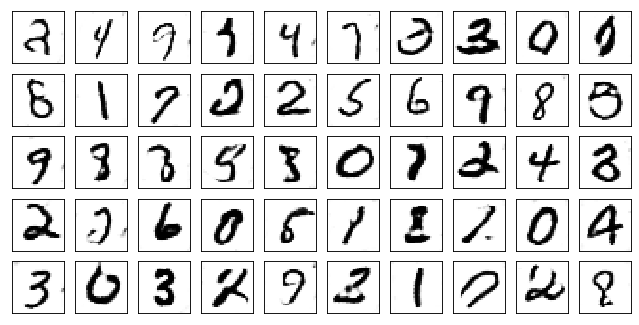

Test losses. G: 0.1454, D: 1.3798 

Train Epoch: 68 [0/50000 (0%)]	Losses G: 1.1061, D: 0.2269
Train Epoch: 68 [25000/50000 (50%)]	Losses G: 4.7666, D: 0.2332
Train Epoch: 68 [50000/50000 (100%)]	Losses G: 3.2579, D: 0.1192


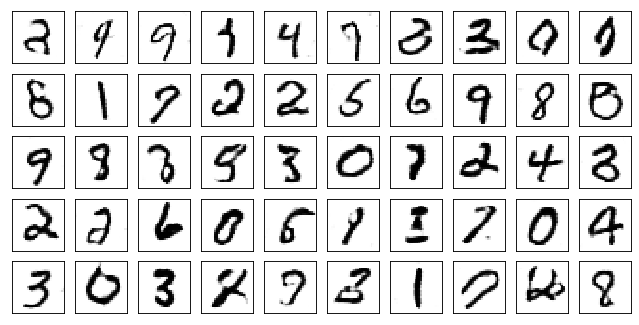

Test losses. G: 4.4067, D: 1.3680 

Train Epoch: 69 [0/50000 (0%)]	Losses G: 2.3484, D: 0.1343
Train Epoch: 69 [25000/50000 (50%)]	Losses G: 3.3373, D: 0.2799
Train Epoch: 69 [50000/50000 (100%)]	Losses G: 1.8351, D: 0.3128


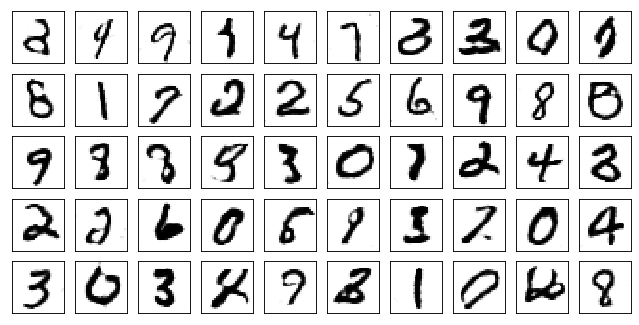

Test losses. G: 2.9183, D: 0.7800 

Train Epoch: 70 [0/50000 (0%)]	Losses G: 1.9750, D: 0.3162
Train Epoch: 70 [25000/50000 (50%)]	Losses G: 2.9155, D: 0.1489
Train Epoch: 70 [50000/50000 (100%)]	Losses G: 2.7480, D: 0.1836


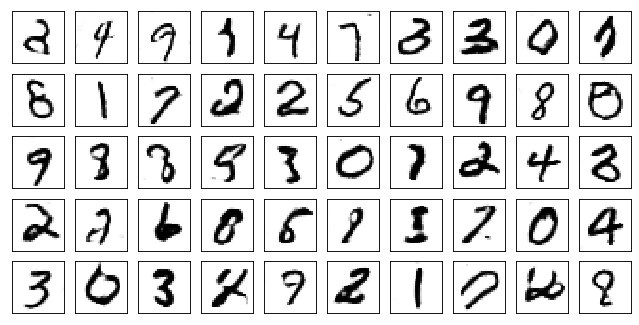

Test losses. G: 2.0383, D: 0.6293 

Train Epoch: 71 [0/50000 (0%)]	Losses G: 2.0365, D: 0.2908
Train Epoch: 71 [25000/50000 (50%)]	Losses G: 2.3988, D: 0.1615
Train Epoch: 71 [50000/50000 (100%)]	Losses G: 1.4058, D: 0.2765


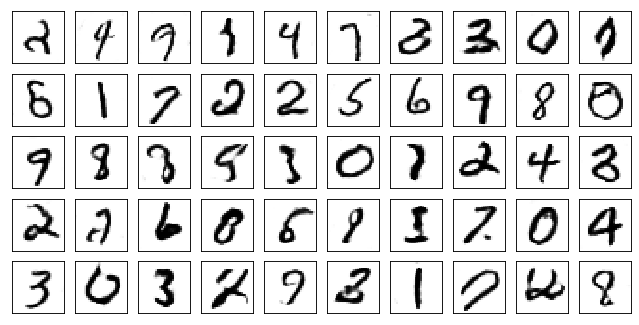

Test losses. G: 1.7954, D: 0.5386 

Train Epoch: 72 [0/50000 (0%)]	Losses G: 2.4734, D: 0.2750
Train Epoch: 72 [25000/50000 (50%)]	Losses G: 1.6675, D: 0.2603
Train Epoch: 72 [50000/50000 (100%)]	Losses G: 2.8683, D: 0.2165


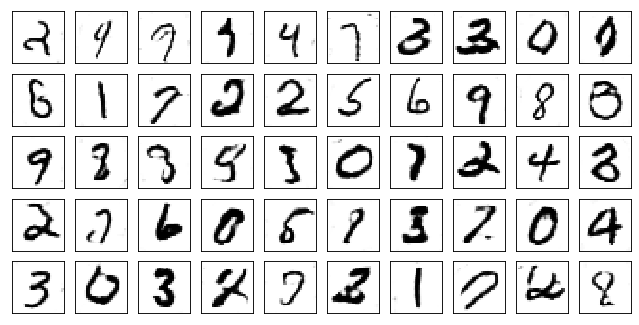

Test losses. G: 0.3660, D: 0.9138 

Train Epoch: 73 [0/50000 (0%)]	Losses G: 2.5905, D: 0.2438
Train Epoch: 73 [25000/50000 (50%)]	Losses G: 3.0639, D: 0.2711
Train Epoch: 73 [50000/50000 (100%)]	Losses G: 2.5438, D: 0.2897


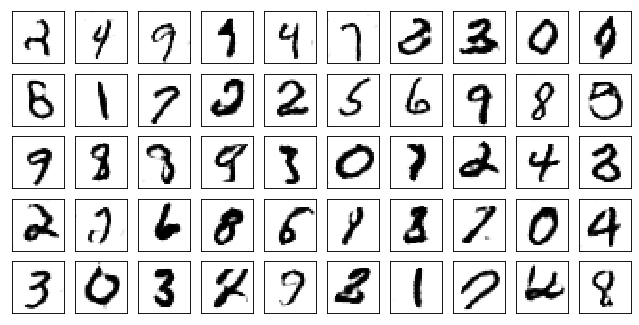

Test losses. G: 1.8575, D: 0.5368 

Train Epoch: 74 [0/50000 (0%)]	Losses G: 2.2712, D: 0.1891
Train Epoch: 74 [25000/50000 (50%)]	Losses G: 2.4711, D: 0.2490
Train Epoch: 74 [50000/50000 (100%)]	Losses G: 1.9921, D: 0.3346


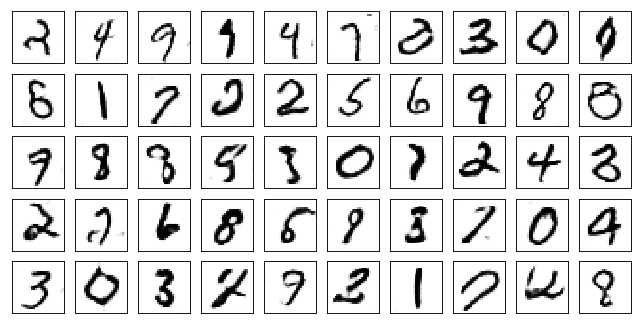

Test losses. G: 2.7429, D: 0.7785 

Train Epoch: 75 [0/50000 (0%)]	Losses G: 3.2120, D: 0.3209
Train Epoch: 75 [25000/50000 (50%)]	Losses G: 3.0806, D: 0.2959
Train Epoch: 75 [50000/50000 (100%)]	Losses G: 1.7340, D: 0.2248


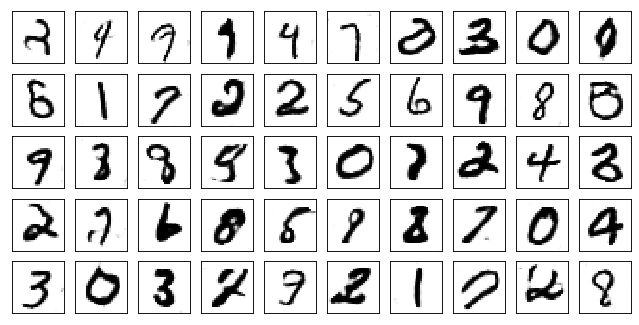

Test losses. G: 0.0552, D: 1.8670 

Train Epoch: 76 [0/50000 (0%)]	Losses G: 2.1498, D: 0.2677
Train Epoch: 76 [25000/50000 (50%)]	Losses G: 2.6949, D: 0.2259
Train Epoch: 76 [50000/50000 (100%)]	Losses G: 1.9580, D: 0.2299


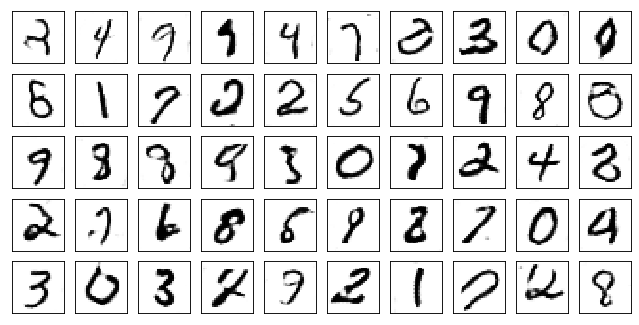

Test losses. G: 3.2185, D: 0.9994 

Train Epoch: 77 [0/50000 (0%)]	Losses G: 2.5232, D: 0.1898
Train Epoch: 77 [25000/50000 (50%)]	Losses G: 2.9759, D: 0.2223
Train Epoch: 77 [50000/50000 (100%)]	Losses G: 1.9001, D: 0.1756


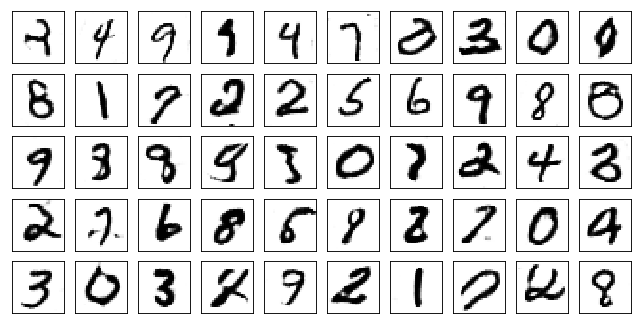

Test losses. G: 3.2299, D: 0.9920 

Train Epoch: 78 [0/50000 (0%)]	Losses G: 2.7424, D: 0.2457
Train Epoch: 78 [25000/50000 (50%)]	Losses G: 2.0892, D: 0.2755
Train Epoch: 78 [50000/50000 (100%)]	Losses G: 2.4893, D: 0.2468


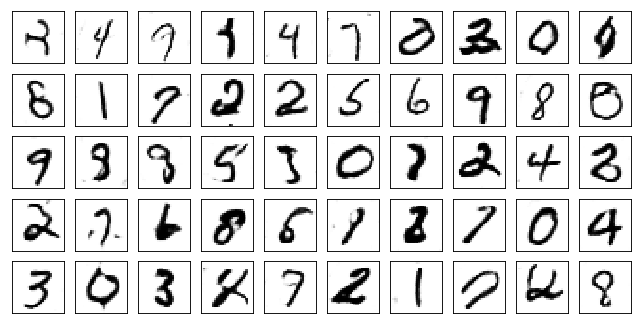

Test losses. G: 0.1501, D: 1.3531 

Train Epoch: 79 [0/50000 (0%)]	Losses G: 3.1583, D: 0.1921
Train Epoch: 79 [25000/50000 (50%)]	Losses G: 2.3779, D: 0.1612
Train Epoch: 79 [50000/50000 (100%)]	Losses G: 3.6223, D: 0.2097


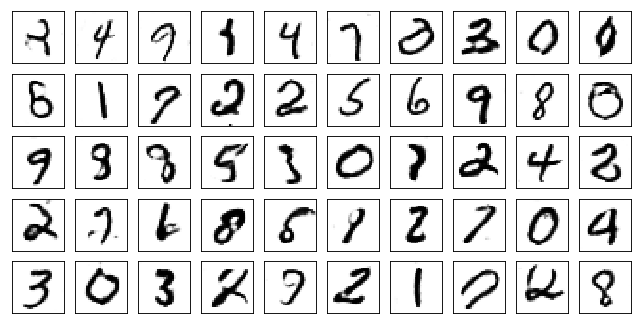

Test losses. G: 3.6685, D: 1.1689 

Train Epoch: 80 [0/50000 (0%)]	Losses G: 4.1476, D: 0.1840
Train Epoch: 80 [25000/50000 (50%)]	Losses G: 3.8672, D: 0.2459
Train Epoch: 80 [50000/50000 (100%)]	Losses G: 1.6438, D: 0.2338


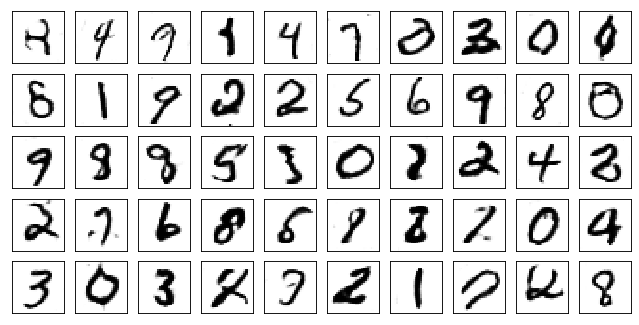

Test losses. G: 1.0301, D: 0.5226 

Train Epoch: 81 [0/50000 (0%)]	Losses G: 1.9261, D: 0.2563
Train Epoch: 81 [25000/50000 (50%)]	Losses G: 2.2945, D: 0.1267
Train Epoch: 81 [50000/50000 (100%)]	Losses G: 3.5347, D: 0.1269


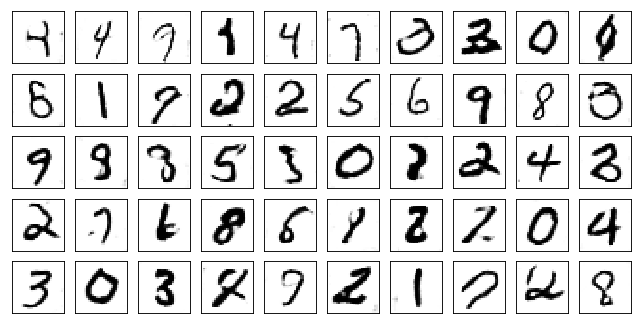

Test losses. G: 0.1967, D: 1.2069 

Train Epoch: 82 [0/50000 (0%)]	Losses G: 3.2522, D: 0.2086
Train Epoch: 82 [25000/50000 (50%)]	Losses G: 5.7052, D: 0.3342
Train Epoch: 82 [50000/50000 (100%)]	Losses G: 1.9874, D: 0.2411


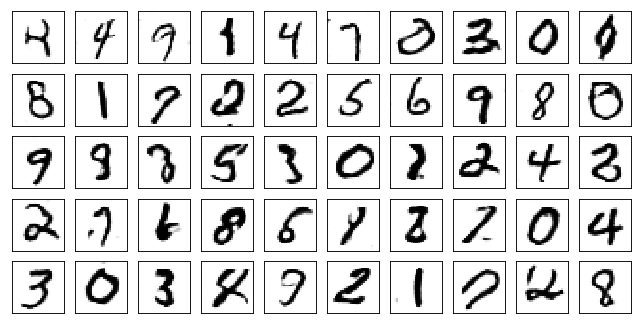

Test losses. G: 1.9577, D: 0.6028 

Train Epoch: 83 [0/50000 (0%)]	Losses G: 1.2306, D: 0.1339
Train Epoch: 83 [25000/50000 (50%)]	Losses G: 2.5438, D: 0.1954
Train Epoch: 83 [50000/50000 (100%)]	Losses G: 0.8044, D: 0.2745


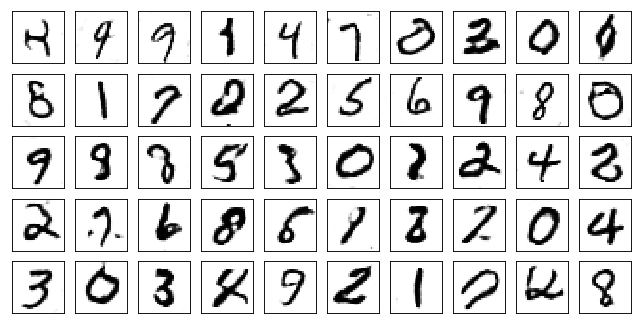

Test losses. G: 1.1289, D: 0.5388 

Train Epoch: 84 [0/50000 (0%)]	Losses G: 2.3590, D: 0.5032
Train Epoch: 84 [25000/50000 (50%)]	Losses G: 1.9131, D: 0.1719
Train Epoch: 84 [50000/50000 (100%)]	Losses G: 2.3085, D: 0.2814


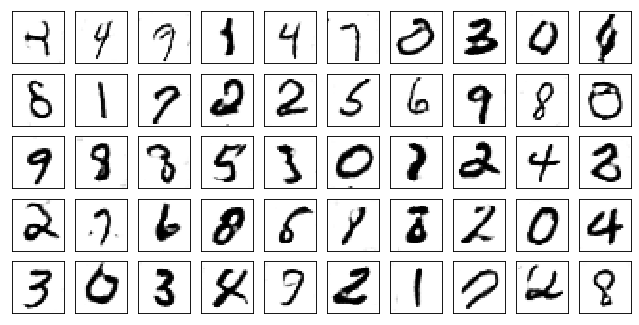

Test losses. G: 1.0585, D: 0.5823 

Train Epoch: 85 [0/50000 (0%)]	Losses G: 3.6603, D: 0.2551
Train Epoch: 85 [25000/50000 (50%)]	Losses G: 2.3785, D: 0.2595
Train Epoch: 85 [50000/50000 (100%)]	Losses G: 2.1240, D: 0.2523


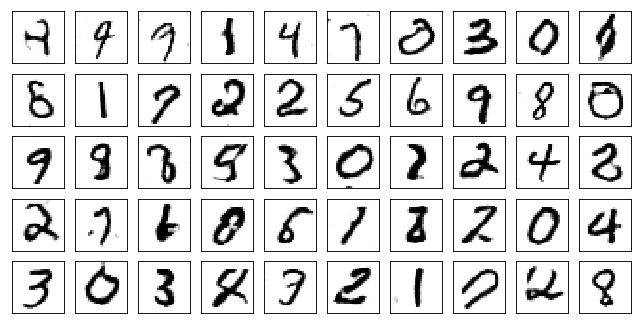

Test losses. G: 3.0257, D: 0.8922 

Train Epoch: 86 [0/50000 (0%)]	Losses G: 2.9656, D: 0.1432
Train Epoch: 86 [25000/50000 (50%)]	Losses G: 3.0745, D: 0.2992
Train Epoch: 86 [50000/50000 (100%)]	Losses G: 2.3708, D: 0.2424


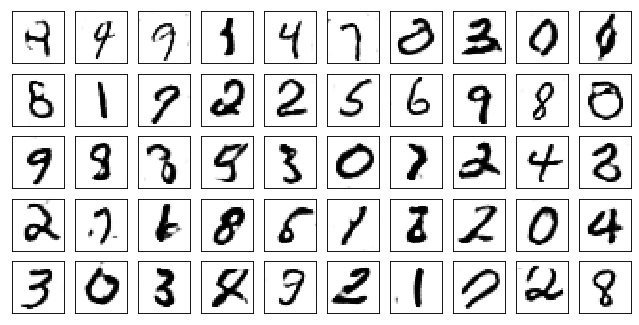

Test losses. G: 2.8881, D: 0.8587 

Train Epoch: 87 [0/50000 (0%)]	Losses G: 2.5790, D: 0.1222
Train Epoch: 87 [25000/50000 (50%)]	Losses G: 1.8757, D: 0.3045
Train Epoch: 87 [50000/50000 (100%)]	Losses G: 3.3940, D: 0.1594


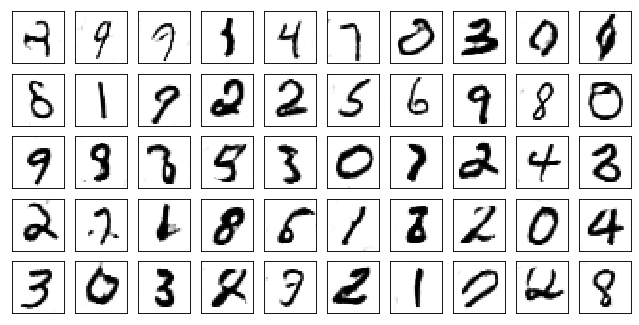

Test losses. G: 0.9713, D: 0.5624 

Train Epoch: 88 [0/50000 (0%)]	Losses G: 3.2004, D: 0.1548
Train Epoch: 88 [25000/50000 (50%)]	Losses G: 1.5585, D: 0.1175
Train Epoch: 88 [50000/50000 (100%)]	Losses G: 4.0952, D: 0.1243


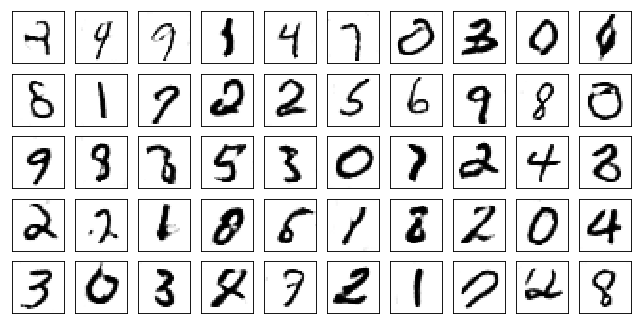

Test losses. G: 0.8602, D: 0.6181 

Train Epoch: 89 [0/50000 (0%)]	Losses G: 4.4504, D: 0.2282
Train Epoch: 89 [25000/50000 (50%)]	Losses G: 2.2957, D: 0.3358
Train Epoch: 89 [50000/50000 (100%)]	Losses G: 3.0355, D: 0.1446


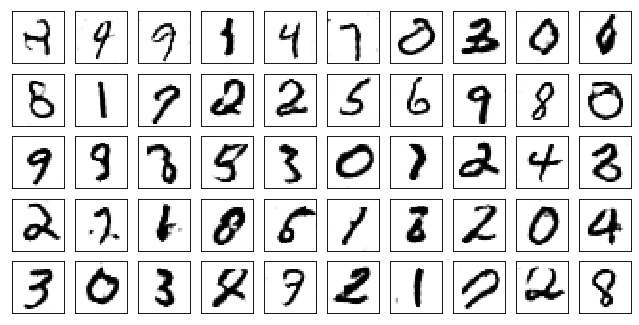

Test losses. G: 5.5216, D: 1.9080 

Train Epoch: 90 [0/50000 (0%)]	Losses G: 3.0729, D: 0.1108
Train Epoch: 90 [25000/50000 (50%)]	Losses G: 4.0715, D: 0.1307
Train Epoch: 90 [50000/50000 (100%)]	Losses G: 1.6989, D: 0.4408


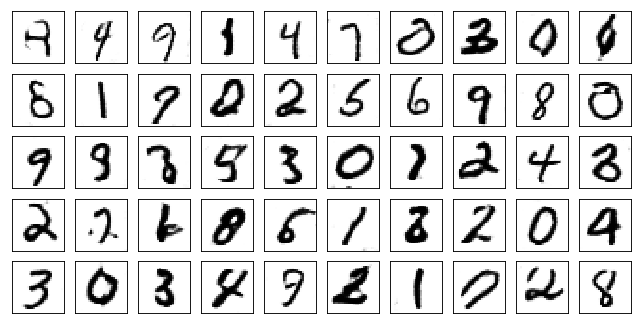

Test losses. G: 0.0821, D: 1.6608 

Train Epoch: 91 [0/50000 (0%)]	Losses G: 1.3736, D: 0.2383
Train Epoch: 91 [25000/50000 (50%)]	Losses G: 2.5755, D: 0.2361
Train Epoch: 91 [50000/50000 (100%)]	Losses G: 2.6439, D: 0.2572


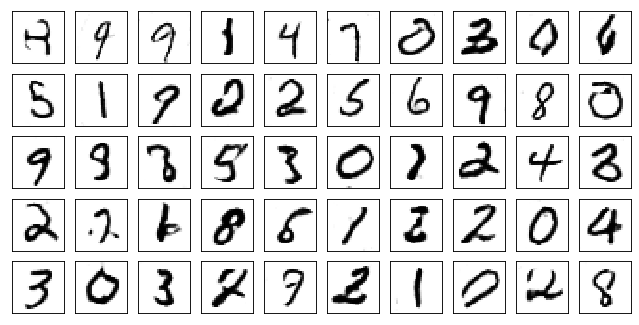

Test losses. G: 1.5792, D: 0.5595 

Train Epoch: 92 [0/50000 (0%)]	Losses G: 1.5973, D: 0.2340
Train Epoch: 92 [25000/50000 (50%)]	Losses G: 2.4527, D: 0.1378
Train Epoch: 92 [50000/50000 (100%)]	Losses G: 3.8823, D: 0.2428


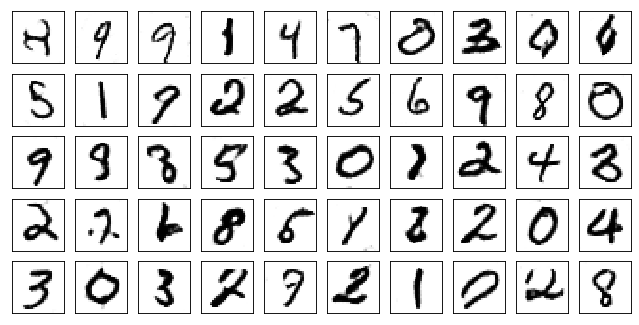

Test losses. G: 8.0539, D: 3.1780 

Train Epoch: 93 [0/50000 (0%)]	Losses G: 4.1343, D: 0.2455
Train Epoch: 93 [25000/50000 (50%)]	Losses G: 3.6428, D: 0.1327
Train Epoch: 93 [50000/50000 (100%)]	Losses G: 3.6800, D: 0.1461


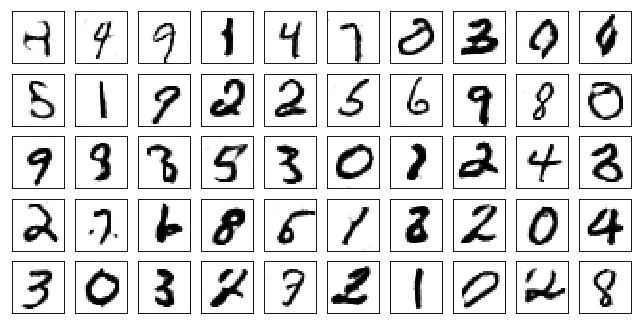

Test losses. G: 0.0818, D: 1.7305 

Train Epoch: 94 [0/50000 (0%)]	Losses G: 2.9937, D: 0.2729
Train Epoch: 94 [25000/50000 (50%)]	Losses G: 2.2210, D: 0.5662
Train Epoch: 94 [50000/50000 (100%)]	Losses G: 3.4331, D: 0.1246


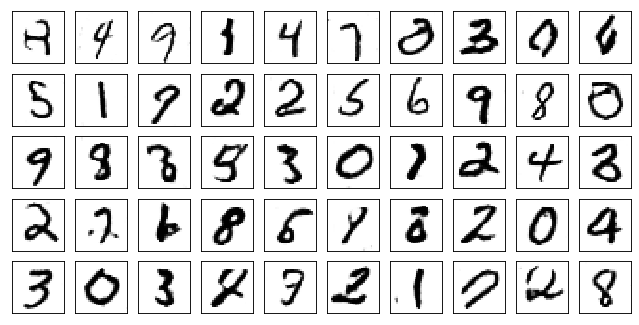

Test losses. G: 3.9447, D: 1.2868 

Train Epoch: 95 [0/50000 (0%)]	Losses G: 3.2224, D: 0.2028
Train Epoch: 95 [25000/50000 (50%)]	Losses G: 3.4907, D: 0.3765
Train Epoch: 95 [50000/50000 (100%)]	Losses G: 3.7251, D: 0.1641


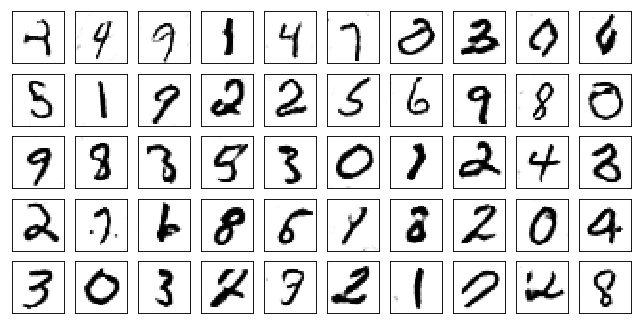

Test losses. G: 6.0573, D: 2.3597 

Train Epoch: 96 [0/50000 (0%)]	Losses G: 3.5478, D: 0.1202
Train Epoch: 96 [25000/50000 (50%)]	Losses G: 2.5947, D: 0.2255
Train Epoch: 96 [50000/50000 (100%)]	Losses G: 1.8721, D: 0.1577


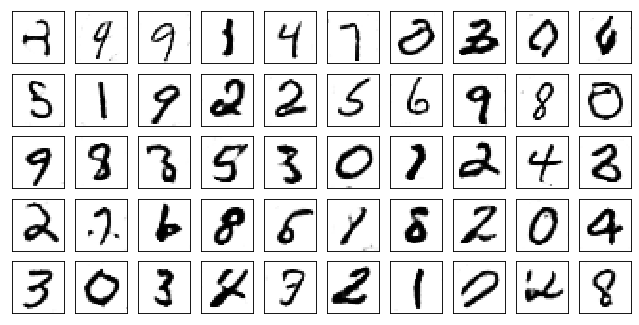

Test losses. G: 1.4173, D: 0.5113 

Train Epoch: 97 [0/50000 (0%)]	Losses G: 1.7007, D: 0.1375
Train Epoch: 97 [25000/50000 (50%)]	Losses G: 1.4312, D: 0.1980
Train Epoch: 97 [50000/50000 (100%)]	Losses G: 2.9143, D: 0.1087


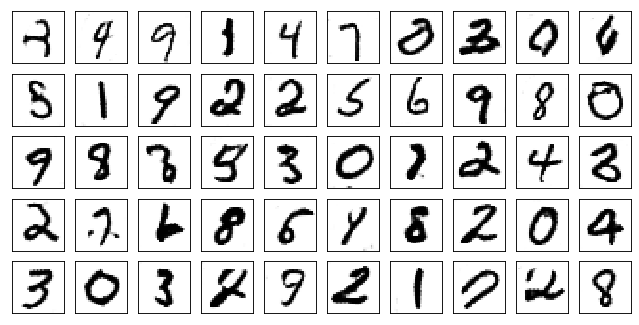

Test losses. G: 5.4983, D: 2.0271 

Train Epoch: 98 [0/50000 (0%)]	Losses G: 3.6419, D: 0.1535
Train Epoch: 98 [25000/50000 (50%)]	Losses G: 2.0257, D: 0.2059
Train Epoch: 98 [50000/50000 (100%)]	Losses G: 2.2937, D: 0.2393


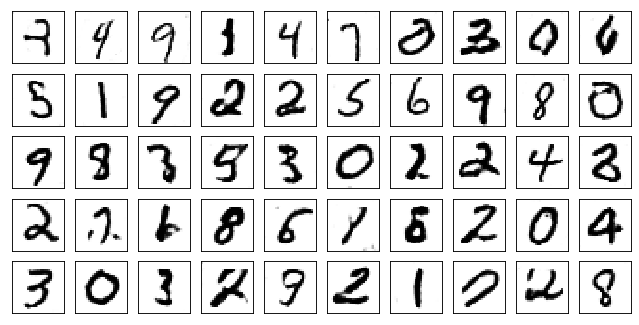

Test losses. G: 3.7713, D: 1.2322 

Train Epoch: 99 [0/50000 (0%)]	Losses G: 1.2148, D: 0.1964
Train Epoch: 99 [25000/50000 (50%)]	Losses G: 3.4059, D: 0.1738
Train Epoch: 99 [50000/50000 (100%)]	Losses G: 3.4986, D: 0.1298


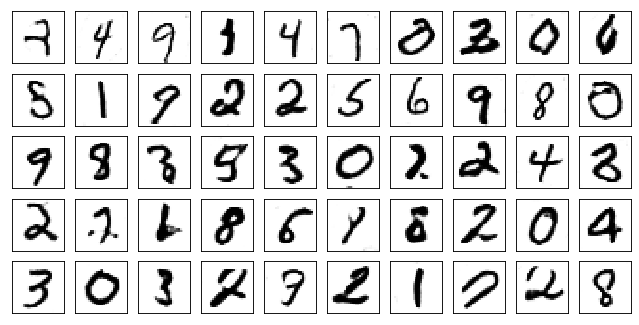

Test losses. G: 2.7372, D: 0.8547 

Train Epoch: 100 [0/50000 (0%)]	Losses G: 2.6015, D: 0.1274
Train Epoch: 100 [25000/50000 (50%)]	Losses G: 3.1702, D: 0.1147
Train Epoch: 100 [50000/50000 (100%)]	Losses G: 2.0473, D: 0.1696


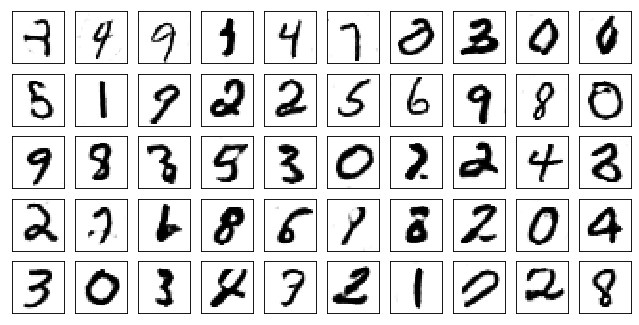

Test losses. G: 3.2987, D: 0.9960 

CPU times: user 48min 23s, sys: 12min 12s, total: 1h 35s
Wall time: 1h 42s


In [20]:
%%time

for epoch in range(1, num_epochs + 1):
    netG.train()
    netD.train()
    train(epoch, netG, netD, train_log)
    netG.eval()
    netD.eval()
    test(netG, netD, valid_loader, epoch, test_log)

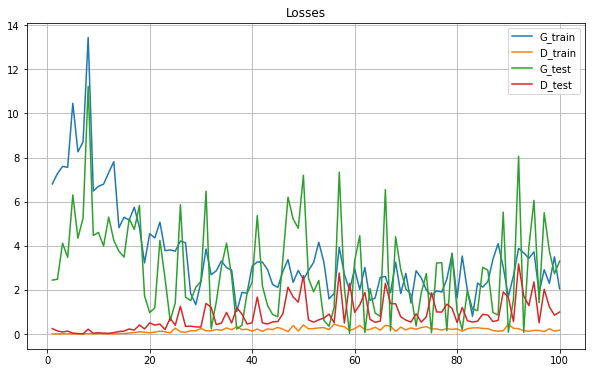

In [22]:
plt.figure(figsize=(10, 6))
for num, logs in enumerate([train_log, test_log]):
    for log in logs:    
        plt.plot(range(1, len(logs[log]) + 1), logs[log], label=log + {0: "_train", 1: "_test"}[num])
plt.title("Losses")
plt.legend()
plt.grid()
plt.show()

### Выводы:


- в целом результат хороший и подавляющее большинство цифр узнаваемы
- основные контуры цифр сформировались уже к 30-й эпохе и далее к 100-й немного улучшились
- результат со сверточным GAN к 30-й эпохе, на мой взгляд, лучше аналогичного результата к 30-й эпохе для полносвязного GAN

